This notebook provides examples for all RDKit molecular descriptors with SMILES examples and calculations.
For original documentaion please refer RDKit Documentation: [https://www.rdkit.org/docs/](https://www.rdkit.org/docs/)

## Table of Contents
1. [**Setup & Installation**](#Installation)
2. [**Descriptor Overview**](#RDKit-Descriptor-Overview)
3. [**Basic Molecular Properties**](#Basic-Molecular-Properties)
4. [**Physicochemical Properties**](#Physicochemical-Properties)
5. [**Charge & Electrostatic Properties**](#Charge-&-Electrostatic-Properties)
6. [**EState Descriptors**](#EState-Descriptors)
7. [**BCUT Descriptors**](#BCUT-Descriptors)
8. [**Topological Descriptors**](#Topological-Descriptors)
9. [**Structural Count Descriptors**](#Structural-Count-Descriptors)
10. [**Fragment Descriptors**](#Fragment-Descriptors)
11. [**Surface Area (VSA) Descriptors**](#Surface-Area-(VSA)-Descriptors)
12. [**Interactive Analysis Tool**](#Interactive-Analysis-Tool)
13. [**Summary & Applications**](#Summary-&-Applications)


# Installation
Run the next cell first if you're in Google Colab:

In [ ]:
# Uncomment and run in Google Colab
# !pip install rdkit==2025.03.3
# !pip install pandas matplotlib seaborn

Check the version of the Rdkit, In this exercise, Rdkit with version 2025.03.3 was use which has 217 descriptors.
The number might change with older or other versions.

In [2]:
import rdkit
print(rdkit.__version__)

2025.03.3


Some prerequisite functions that will be use later for visulization etc, which is part of the setup.

In [3]:
# Import required libraries
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, rdMolDescriptors
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, SVG
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Helper function to calculate all descriptors for a molecule
def getMolDescriptors(smiles, missingVal=None):
    """Calculate all RDKit descriptors for a SMILES string"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"Invalid SMILES: {smiles}")
        return None
    
    res = {}
    for nm, fn in Descriptors._descList:
        try:
            val = fn(mol)
        except:
            val = missingVal
        res[nm] = val
    return res

# Helper function to display descriptor values for multiple molecules
def compare_descriptors(smiles_list, descriptor_names, molecule_names=None):
    """Compare specific descriptors across multiple molecules"""
    if molecule_names is None:
        molecule_names = [f"Mol_{i+1}" for i in range(len(smiles_list))]
    
    data = []
    for i, smiles in enumerate(smiles_list):
        descriptors = getMolDescriptors(smiles)
        if descriptors:
            row = {'Molecule': molecule_names[i], 'SMILES': smiles}
            for desc in descriptor_names:
                row[desc] = round(descriptors.get(desc, 0), 3)
            data.append(row)
    
    return pd.DataFrame(data)

# Function to visualize molecules with highlighting
def visualize_molecules_with_properties(smiles_list, names_list, property_values=None, 
                                      property_name="Property", size=(300, 300)):
    """Display molecules with optional property highlighting"""
    mols = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            mols.append(mol)
        else:
            mols.append(None)
    
    # Create molecule grid with labels
    if property_values:
        labels = [f"{name}\n{property_name}: {val:.2f}" 
                 for name, val in zip(names_list, property_values)]
    else:
        labels = names_list
    
    img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=size, 
                              legends=labels, returnPNG=False)
    return img

# Function to highlight atoms based on properties
def highlight_atoms_by_property(smiles, property_func, title="Highlighted Atoms"):
    """Highlight atoms in a molecule based on a property function"""
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None
    
    # Calculate property for each atom
    atom_props = []
    for atom in mol.GetAtoms():
        prop_val = property_func(atom)
        atom_props.append(prop_val)
    
    # Normalize properties for coloring (0-1 scale)
    if max(atom_props) != min(atom_props):
        norm_props = [(p - min(atom_props)) / (max(atom_props) - min(atom_props)) 
                     for p in atom_props]
    else:
        norm_props = [0.5] * len(atom_props)
    
    # Create highlight colors (red scale)
    colors = {}
    for i, prop in enumerate(norm_props):
        colors[i] = (1.0, 1.0 - prop, 1.0 - prop)  # Red gradient
    
    # Generate highlighted image
    drawer = rdMolDraw2D.MolDraw2DSVG(400, 400)
    drawer.DrawMolecule(mol, highlightAtoms=list(range(mol.GetNumAtoms())), 
                       highlightAtomColors=colors)
    drawer.FinishDrawing()
    
    return SVG(drawer.GetDrawingText())

# Function to create property correlation heatmap
def plot_descriptor_correlation(smiles_list, descriptor_names, molecule_names):
    """Create a correlation heatmap for selected descriptors"""
    df = compare_descriptors(smiles_list, descriptor_names, molecule_names)
    
    # Calculate correlation matrix
    corr_data = df[descriptor_names].corr()
    
    # Create heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_data, annot=True, cmap='coolwarm', center=0, 
                square=True, fmt='.2f')
    plt.title('Descriptor Correlation Matrix')
    plt.tight_layout()
    plt.show()

print(" Setup complete! Ready to explore molecular descriptors with visualizations.")
print(" Available functions:")
print("  • visualize_molecules_with_properties() - Show molecule structures with property values")
print("  • highlight_atoms_by_property() - Highlight atoms based on properties")
print("  • plot_descriptor_correlation() - Create descriptor correlation heatmaps")

 Setup complete! Ready to explore molecular descriptors with visualizations.
 Available functions:
  • visualize_molecules_with_properties() - Show molecule structures with property values
  • highlight_atoms_by_property() - Highlight atoms based on properties
  • plot_descriptor_correlation() - Create descriptor correlation heatmaps


## RDKit Descriptor Overview

Let's first see how many descriptors are available and what they are:
Note: This information might not be complete


In [4]:
from rdkit.Chem import Descriptors
print(f"Total number of RDKit descriptors: {len(Descriptors._descList)}")


# Get list of all descriptor names
deslist = [x[0] for x in Descriptors._descList]
print(f"\nAll {len(deslist)} descriptor names:")
for i, desc in enumerate(deslist):
    if i % 5 == 0:
        print()
    print(f"{desc:<25}", end="")

Total number of RDKit descriptors: 217

All 217 descriptor names:

MaxAbsEStateIndex        MaxEStateIndex           MinAbsEStateIndex        MinEStateIndex           qed                      
SPS                      MolWt                    HeavyAtomMolWt           ExactMolWt               NumValenceElectrons      
NumRadicalElectrons      MaxPartialCharge         MinPartialCharge         MaxAbsPartialCharge      MinAbsPartialCharge      
FpDensityMorgan1         FpDensityMorgan2         FpDensityMorgan3         BCUT2D_MWHI              BCUT2D_MWLOW             
BCUT2D_CHGHI             BCUT2D_CHGLO             BCUT2D_LOGPHI            BCUT2D_LOGPLOW           BCUT2D_MRHI              
BCUT2D_MRLOW             AvgIpc                   BalabanJ                 BertzCT                  Chi0                     
Chi0n                    Chi0v                    Chi1                     Chi1n                    Chi1v                    
Chi2n                    Chi2v                    C

## Descriptor Overview

Let's explore what descriptors are available in RDKit and how they're organized.

In [5]:
# RDKit Descriptor Overview
print(" RDKit Molecular Descriptors Overview")
print("=" * 50)

# Get all descriptor names
all_descriptors = [name for name, func in Descriptors._descList]

# Categorize descriptors with improved classification
categories = {
    'Basic Properties': ['MolWt', 'ExactMolWt', 'HeavyAtomMolWt', 'NumValenceElectrons', 'NumRadicalElectrons'],
    'Physicochemical': ['MolLogP', 'MolMR', 'qed', 'SPS'],
    'Charge Properties': ['MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge'],
    'EState Descriptors': ['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex'],
    'BCUT Descriptors': ['BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW'],
    'Topological': [d for d in all_descriptors if any(x in d for x in ['Chi', 'Kappa', 'BalabanJ', 'BertzCT', 'Ipc', 'Phi', 'HallKierAlpha', 'AvgIpc'])],
    'Surface Area (VSA)': [d for d in all_descriptors if 'VSA' in d or d in ['TPSA', 'LabuteASA']],
    'Structural Counts': [d for d in all_descriptors if (d.startswith('Num') and d not in ['NumValenceElectrons', 'NumRadicalElectrons']) or \
                               (d in ['RingCount', 'FractionCSP3', 'HeavyAtomCount', 'NHOHCount', 'NOCount']) or \
                               d.startswith('FpDensity')],
    'Fragment Counts': [d for d in all_descriptors if d.startswith('fr_')],
}

print(" Descriptor Categories:")
print("-" * 30)

for category, descriptors in categories.items():
    count = len(descriptors)
    percentage = (count / len(all_descriptors)) * 100
    print(f"{category:<20}: {count:>3} descriptors ({percentage:.1f}%)")


    print(f"Total descriptors available: {len(Descriptors._descList)}")

 RDKit Molecular Descriptors Overview
 Descriptor Categories:
------------------------------
Basic Properties    :   5 descriptors (2.3%)
Total descriptors available: 217
Physicochemical     :   4 descriptors (1.8%)
Total descriptors available: 217
Charge Properties   :   4 descriptors (1.8%)
Total descriptors available: 217
EState Descriptors  :   4 descriptors (1.8%)
Total descriptors available: 217
BCUT Descriptors    :   8 descriptors (3.7%)
Total descriptors available: 217
Topological         :  21 descriptors (9.7%)
Total descriptors available: 217
Surface Area (VSA)  :  59 descriptors (27.2%)
Total descriptors available: 217
Structural Counts   :  27 descriptors (12.4%)
Total descriptors available: 217
Fragment Counts     :  85 descriptors (39.2%)
Total descriptors available: 217


# Basic Molecular Properties

### Molecular Weight Descriptors
Let's start with the most fundamental molecular descriptors - molecular weights.

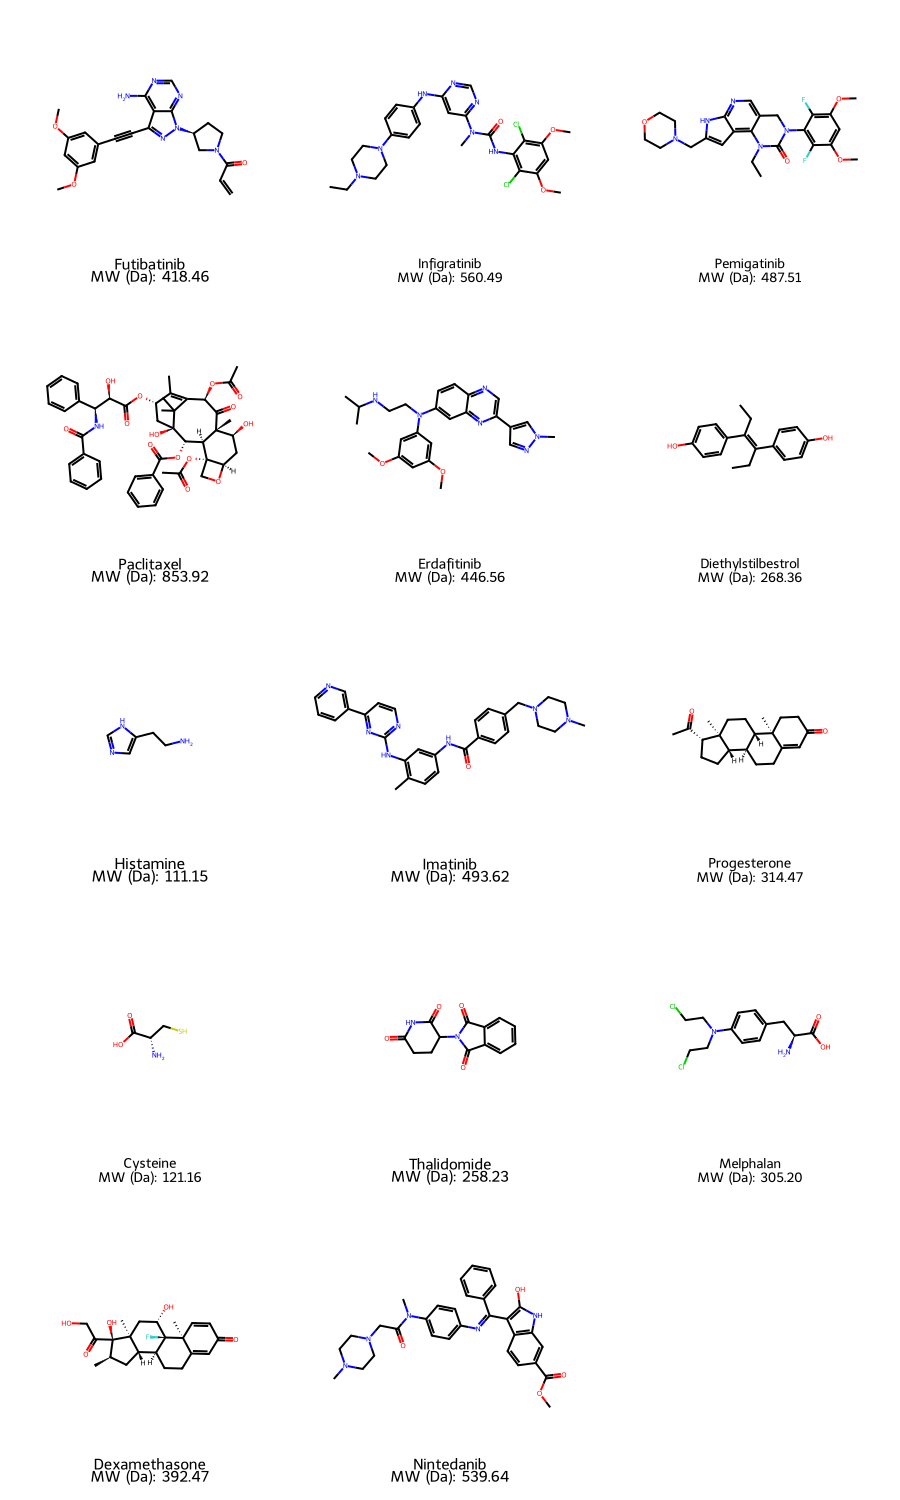

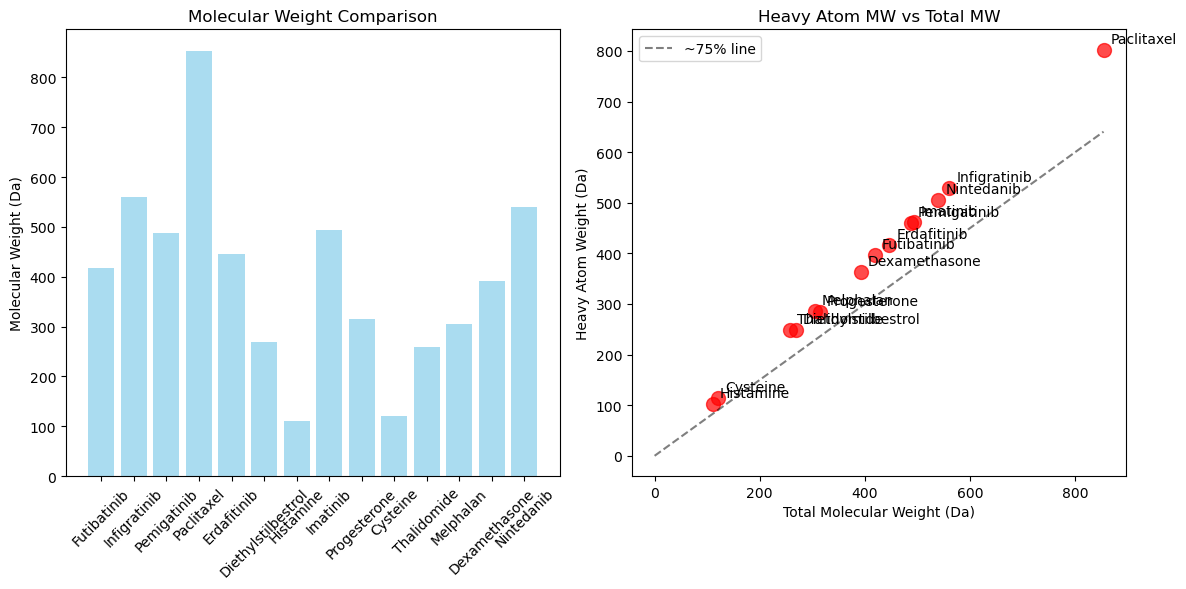

 Interpretation:
• MolWt: Average molecular weight (includes isotopic averages)
• ExactMolWt: Exact mass using most abundant isotopes
• HeavyAtomMolWt: Molecular weight excluding hydrogens
• Notice: HeavyAtomMolWt is typically ~65-75% of total molecular weight
• Drug-like range: MW ≤ 500 Da (Lipinski's Rule)

 Drug-likeness Assessment:
  Futibatinib: 418.5 Da - follows Lipinski's Rule
  Infigratinib: 560.5 Da - Do not follow Lipinski's Rule
  Pemigatinib: 487.5 Da - follows Lipinski's Rule
  Paclitaxel: 853.9 Da - Do not follow Lipinski's Rule
  Erdafitinib: 446.6 Da - follows Lipinski's Rule
  Diethylstilbestrol: 268.4 Da - follows Lipinski's Rule
  Histamine: 111.1 Da - follows Lipinski's Rule
  Imatinib: 493.6 Da - follows Lipinski's Rule
  Progesterone: 314.5 Da - follows Lipinski's Rule
  Cysteine: 121.2 Da - follows Lipinski's Rule
  Thalidomide: 258.2 Da - follows Lipinski's Rule
  Melphalan: 305.2 Da - follows Lipinski's Rule
  Dexamethasone: 392.5 Da - follows Lipinski's Rule


In [6]:
# Lets take some of the FGFR drugs as an examples

drug_smiles = {
    "Futibatinib": "COC1=CC(=CC(=C1)C#CC2=NN(C3=NC=NC(=C23)N)[C@H]4CCN(C4)C(=O)C=C)OC",
    "Infigratinib": "CCN1CCN(CC1)C2=CC=C(C=C2)NC3=CC(=NC=N3)N(C)C(=O)NC4=C(C(=CC(=C4Cl)OC)OC)Cl",
    "Pemigatinib": "CCN1C2=C3C=C(NC3=NC=C2CN(C1=O)C4=C(C(=CC(=C4F)OC)OC)F)CN5CCOCC5",
    "Paclitaxel": "CC1=C2[C@H](C(=O)[C@@]3([C@H](C[C@@H]4[C@]([C@H]3[C@@H]([C@@](C2(C)C)(C[C@@H]1OC(=O)[C@@H]([C@H](C5=CC=CC=C5)NC(=O)C6=CC=CC=C6)O)O)OC(=O)C7=CC=CC=C7)(CO4)OC(=O)C)O)C)OC(=O)C",
    "Erdafitinib": "CC(C)NCCN(C1=CC2=NC(=CN=C2C=C1)C3=CN(N=C3)C)C4=CC(=CC(=C4)OC)OC",
    "Diethylstilbestrol": "CC/C(=C(/CC)\\C1=CC=C(C=C1)O)/C2=CC=C(C=C2)O",
    "Histamine": "C1=C(NC=N1)CCN",
    "Imatinib": "CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C)NC4=NC=CC(=N4)C5=CN=CC=C5",
    "Progesterone": "CC(=O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2CCC4=CC(=O)CC[C@]34C)C",
    "Cysteine": "C([C@@H](C(=O)O)N)S",
    "Thalidomide": "C1CC(=O)NC(=O)C1N2C(=O)C3=CC=CC=C3C2=O",
    "Melphalan": "C1=CC(=CC=C1C[C@@H](C(=O)O)N)N(CCCl)CCCl",
    "Dexamethasone": "C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@@]4([C@]3([C@H](C[C@@]2([C@]1(C(=O)CO)O)C)O)F)C",
    "Nintedanib": "CN1CCN(CC1)CC(=O)N(C)C2=CC=C(C=C2)N=C(C3=CC=CC=C3)C4=C(NC5=C4C=CC(=C5)C(=O)OC)O",
}

drug_smiles_list = list(drug_smiles.values())
drug_names_list = list(drug_smiles.keys())
mw_descriptors = ['MolWt', 'ExactMolWt', 'HeavyAtomMolWt']
mw_df = compare_descriptors(drug_smiles_list, mw_descriptors, drug_names_list)

# print(" Molecular Weight Descriptors:")
# print("=" * 60)
# print(mw_df)

# Visualize molecules with molecular weights
mol_weights = [getMolDescriptors(smiles)['MolWt'] for smiles in drug_smiles_list]
img = visualize_molecules_with_properties(drug_smiles_list, drug_names_list, mol_weights, "MW (Da)")
display(img)

# Create molecular weight comparison chart
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(drug_names_list, mol_weights, color='skyblue', alpha=0.7)
plt.title('Molecular Weight Comparison')
plt.ylabel('Molecular Weight (Da)')
plt.xticks(rotation=45)

# Show relationship between MW and Heavy Atom MW
heavy_weights = [getMolDescriptors(smiles)['HeavyAtomMolWt'] for smiles in drug_smiles_list]
plt.subplot(1, 2, 2)
plt.scatter(mol_weights, heavy_weights, color='red', s=100, alpha=0.7)
for i, name in enumerate(drug_names_list):
    plt.annotate(name, (mol_weights[i], heavy_weights[i]), 
                xytext=(5, 5), textcoords='offset points')
plt.xlabel('Total Molecular Weight (Da)')
plt.ylabel('Heavy Atom Weight (Da)')
plt.title('Heavy Atom MW vs Total MW')

# Add diagonal line showing relationship
max_mw = max(mol_weights)
plt.plot([0, max_mw], [0, max_mw*0.75], 'k--', alpha=0.5, label='~75% line')
plt.legend()

plt.tight_layout()
plt.show()

print(" Interpretation:")
print("• MolWt: Average molecular weight (includes isotopic averages)")
print("• ExactMolWt: Exact mass using most abundant isotopes")  
print("• HeavyAtomMolWt: Molecular weight excluding hydrogens")
print("• Notice: HeavyAtomMolWt is typically ~65-75% of total molecular weight")
print(f"• Drug-like range: MW ≤ 500 Da (Lipinski's Rule)")

# Highlight drug-like vs non-drug-like
print("\n Drug-likeness Assessment:")
for i, (name, mw) in enumerate(zip(drug_names_list, mol_weights)):
    status = "follows Lipinski's Rule" if mw <= 500 else "Do not follow Lipinski's Rule"
    print(f"  {name}: {mw:.1f} Da - {status}") 

Though all the molecules are approved drugs they still breark Lipinski's Rule of 5 with respect to molecular weight.

## Basic Molecular Properties some additional descriptors

Let's start with the fundamental molecular properties: molecular weights and basic electronic properties.

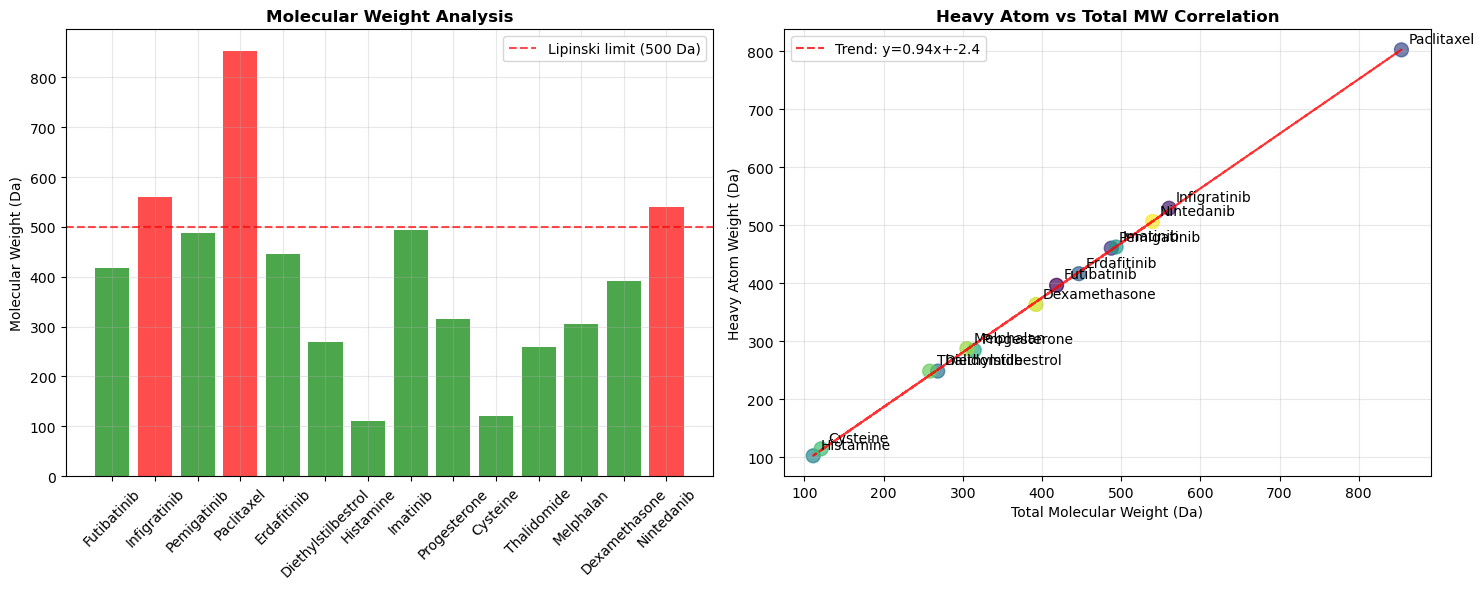

Key Insights:
Molecular weights range from 111.1 to 853.9 Da
Heavy atom weight is typically 94% of total MW


In [7]:
basic_descriptors = ['MolWt', 'ExactMolWt', 'HeavyAtomMolWt', 'NumValenceElectrons', 'NumRadicalElectrons']
basic_df = compare_descriptors(drug_smiles_list, basic_descriptors, drug_names_list)

# print(" Basic Molecular Properties")
# print("=" * 60)
# print(basic_df)

# Visualize molecules with molecular weights
mol_weights = [getMolDescriptors(smiles)['MolWt'] for smiles in drug_smiles_list]
img = visualize_molecules_with_properties( drug_smiles_list, drug_names_list,mol_weights, "MW (Da)")
# Here molecule is not visualized as it is already shown in some above cell
# display(img)

# Create analysis plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Molecular weight comparison
colors = ['green' if mw <= 500 else 'red' for mw in mol_weights]
axes[0].bar(drug_names_list, mol_weights, color=colors, alpha=0.7)
axes[0].axhline(y=500, color='red', linestyle='--', alpha=0.7, label='Lipinski limit (500 Da)')
axes[0].set_title('Molecular Weight Analysis', fontweight='bold')
axes[0].set_ylabel('Molecular Weight (Da)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Heavy atom weight correlation
heavy_weights = [getMolDescriptors(smiles)['HeavyAtomMolWt'] for smiles in drug_smiles_list]
axes[1].scatter(mol_weights, heavy_weights, s=100, alpha=0.7, c=range(len(drug_names_list)), cmap='viridis')
for i, name in enumerate(drug_names_list):
    axes[1].annotate(name, (mol_weights[i], heavy_weights[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=10)

# Add trend line
z = np.polyfit(mol_weights, heavy_weights, 1)
p = np.poly1d(z)
axes[1].plot(mol_weights, p(mol_weights), "r--", alpha=0.8, label=f'Trend: y={z[0]:.2f}x+{z[1]:.1f}')

axes[1].set_xlabel('Total Molecular Weight (Da)')
axes[1].set_ylabel('Heavy Atom Weight (Da)')
axes[1].set_title('Heavy Atom vs Total MW Correlation', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Interpretation
print("Key Insights:")
print(f"Molecular weights range from {min(mol_weights):.1f} to {max(mol_weights):.1f} Da")
print(f"Heavy atom weight is typically {100*np.mean([h/m for h, m in zip(heavy_weights, mol_weights)]):.0f}% of total MW")


# Physicochemical Properties

These descriptors are crucial for understanding drug-like properties and ADMET characteristics.

 Physicochemical Properties
        Molecule                        SMILES  MolLogP   MolMR    qed     SPS
0        Ethanol                           CCO   -0.001  12.760  0.407   6.000
1         Octane                      CCCCCCCC    3.367  39.050  0.481   9.750
2        Aspirin      CC(=O)OC1=CC=CC=C1C(=O)O    1.310  44.710  0.550   9.308
3       Caffeine  CN1C=NC2=C1C(=O)N(C(=O)N2C)C   -1.029  51.196  0.538  11.071
4  Triethylamine                     CCN(CC)CC    1.348  33.462  0.518  10.286
5        Decalin                C1CCC2CCCCC2C1    3.367  43.916  0.481  40.800


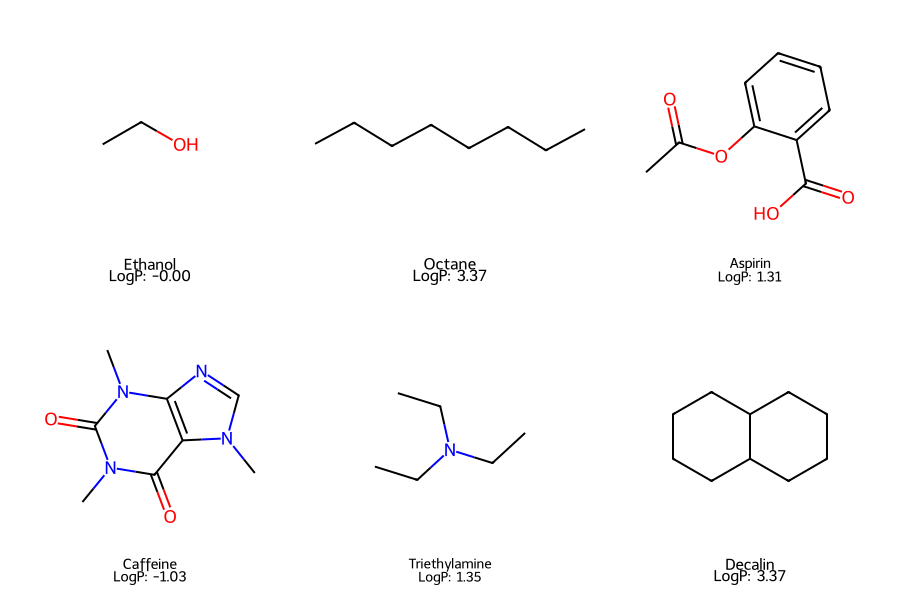

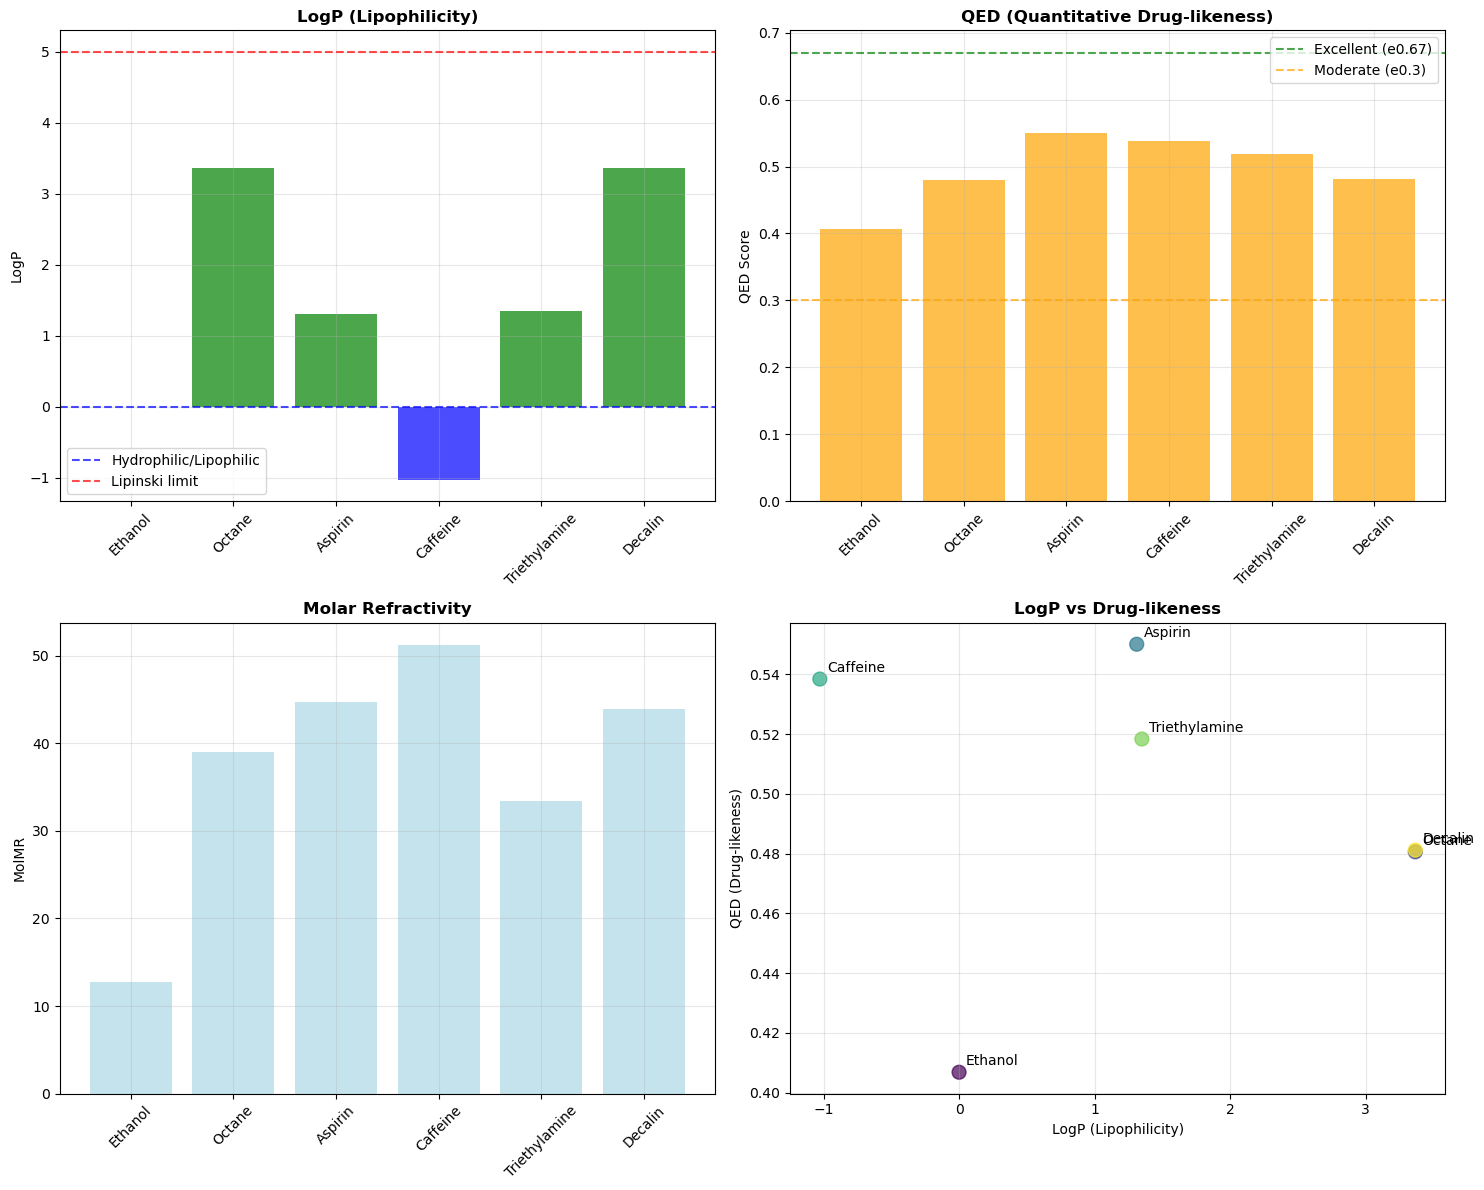

Property Interpretation Guide:
----------------------------------------
LogP (Lipophilicity):
  < 0    : Very hydrophilic (water-loving)
  0-2    : Balanced hydrophilic/lipophilic
  2-5    : Lipophilic (fat-loving)
  > 5    : Very lipophilic (may have poor solubility)

QED (Drug-likeness):
  0.0-0.3: Poor drug-likeness
  0.3-0.67: Moderate drug-likeness
  0.67-1.0: Excellent drug-likeness
Individual Molecule Assessments:
--------------------------------------------------
Ethanol:
  LogP: -0.00 (Hydrophilic)
  QED: 0.41 (Moderate drug-likeness)
  MolMR: 12.8 (molecular volume/polarizability)
Octane:
  LogP: 3.37 (Lipophilic)
  QED: 0.48 (Moderate drug-likeness)
  MolMR: 39.0 (molecular volume/polarizability)
Aspirin:
  LogP: 1.31 (Balanced)
  QED: 0.55 (Moderate drug-likeness)
  MolMR: 44.7 (molecular volume/polarizability)
Caffeine:
  LogP: -1.03 (Hydrophilic)
  QED: 0.54 (Moderate drug-likeness)
  MolMR: 51.2 (molecular volume/polarizability)
Triethylamine:
  LogP: 1.35 (Balanced)
  Q

In [8]:
# Physicochemical Properties Analysis

# Diverse molecules showing different physicochemical properties
physico_examples = [
    "CCO",                                  # Ethanol (hydrophilic)
    "CCCCCCCC",                            # Octane (lipophilic)
    "CC(=O)OC1=CC=CC=C1C(=O)O",            # Aspirin (balanced)
    "CN1C=NC2=C1C(=O)N(C(=O)N2C)C",        # Caffeine (drug-like)
    "CCN(CC)CC",                           # Triethylamine (basic)
    "C1CCC2CCCCC2C1",                      # Decalin (rigid, complex)
]

physico_names = ["Ethanol", "Octane", "Aspirin", "Caffeine", "Triethylamine", "Decalin"]

# if you want to see for previous drug molecules uncommnet the below, it will override with drug molecules 

# physico_examples = list(drug_smiles.values())
# physico_names  = list(drug_smiles.keys())


# Calculate physicochemical descriptors
physico_descriptors = ['MolLogP', 'MolMR', 'qed', 'SPS']
physico_df = compare_descriptors(physico_examples, physico_descriptors, physico_names)

print(" Physicochemical Properties")
print("=" * 60)
print(physico_df)

# Visualize molecules with LogP values
logp_values = [getMolDescriptors(smiles)['MolLogP'] for smiles in physico_examples]
img = visualize_molecules_with_properties(physico_examples, physico_names, logp_values, "LogP")
display(img)

# Create comprehensive analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# LogP analysis
logp_colors = ['blue' if lp < 0 else 'green' if lp <= 5 else 'red' for lp in logp_values]
axes[0,0].bar(physico_names, logp_values, color=logp_colors, alpha=0.7)
axes[0,0].axhline(y=0, color='blue', linestyle='--', alpha=0.7, label='Hydrophilic/Lipophilic')
axes[0,0].axhline(y=5, color='red', linestyle='--', alpha=0.7, label='Lipinski limit')
axes[0,0].set_title('LogP (Lipophilicity)', fontweight='bold')
axes[0,0].set_ylabel('LogP')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# QED (Drug-likeness)
qed_values = [getMolDescriptors(smiles)['qed'] for smiles in physico_examples]
qed_colors = ['red' if qed < 0.3 else 'orange' if qed < 0.67 else 'green' for qed in qed_values]
axes[0,1].bar(physico_names, qed_values, color=qed_colors, alpha=0.7)
axes[0,1].axhline(y=0.67, color='green', linestyle='--', alpha=0.7, label='Excellent (e0.67)')
axes[0,1].axhline(y=0.3, color='orange', linestyle='--', alpha=0.7, label='Moderate (e0.3)')
axes[0,1].set_title('QED (Quantitative Drug-likeness)', fontweight='bold')
axes[0,1].set_ylabel('QED Score')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Molar Refractivity
mr_values = [getMolDescriptors(smiles)['MolMR'] for smiles in physico_examples]
axes[1,0].bar(physico_names, mr_values, color='lightblue', alpha=0.7)
axes[1,0].set_title('Molar Refractivity', fontweight='bold')
axes[1,0].set_ylabel('MolMR')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

# LogP vs QED correlation
scatter = axes[1,1].scatter(logp_values, qed_values, s=100, alpha=0.7, 
                           c=range(len(physico_names)), cmap='viridis')
for i, name in enumerate(physico_names):
    axes[1,1].annotate(name, (logp_values[i], qed_values[i]), 
                      xytext=(5, 5), textcoords='offset points', fontsize=10)
axes[1,1].set_xlabel('LogP (Lipophilicity)')
axes[1,1].set_ylabel('QED (Drug-likeness)')
axes[1,1].set_title('LogP vs Drug-likeness', fontweight='bold')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed interpretation
print("Property Interpretation Guide:")
print("-" * 40)
print("LogP (Lipophilicity):")
print("  < 0    : Very hydrophilic (water-loving)")
print("  0-2    : Balanced hydrophilic/lipophilic")
print("  2-5    : Lipophilic (fat-loving)")
print("  > 5    : Very lipophilic (may have poor solubility)")

print("\nQED (Drug-likeness):")
print("  0.0-0.3: Poor drug-likeness")
print("  0.3-0.67: Moderate drug-likeness")
print("  0.67-1.0: Excellent drug-likeness")

# Individual assessments
print("Individual Molecule Assessments:")
print("-" * 50)
for i, name in enumerate(physico_names):
    logp_cat = "Hydrophilic" if logp_values[i] < 0 else "Balanced" if logp_values[i] <= 2 else "Lipophilic" if logp_values[i] <= 5 else "Very lipophilic"
    qed_cat = "Poor" if qed_values[i] < 0.3 else "Moderate" if qed_values[i] < 0.67 else "Excellent"
    
    print(f"{name}:")
    print(f"  LogP: {logp_values[i]:.2f} ({logp_cat})")
    print(f"  QED: {qed_values[i]:.2f} ({qed_cat} drug-likeness)")
    print(f"  MolMR: {mr_values[i]:.1f} (molecular volume/polarizability)")

# Charge & Electrostatic Properties

These descriptors help predict molecular reactivity and interaction sites by analyzing partial charge distribution.

Partial Charge Analysis
      Molecule       SMILES  MaxPartialCharge  MinPartialCharge  \
0      Ethanol          CCO             0.040            -0.397   
1      Acetone      CC(=O)C             0.126            -0.300   
2   Ethylamine          CCN            -0.011            -0.331   
3  Acetic acid      CC(=O)O             0.300            -0.481   
4       Ethene          C=C            -0.106            -0.106   
5      Benzene  C1=CC=CC=C1            -0.062            -0.062   

   MaxAbsPartialCharge  MinAbsPartialCharge  
0                0.397                0.040  
1                0.300                0.126  
2                0.331                0.011  
3                0.481                0.300  
4                0.106                0.106  
5                0.062                0.062  


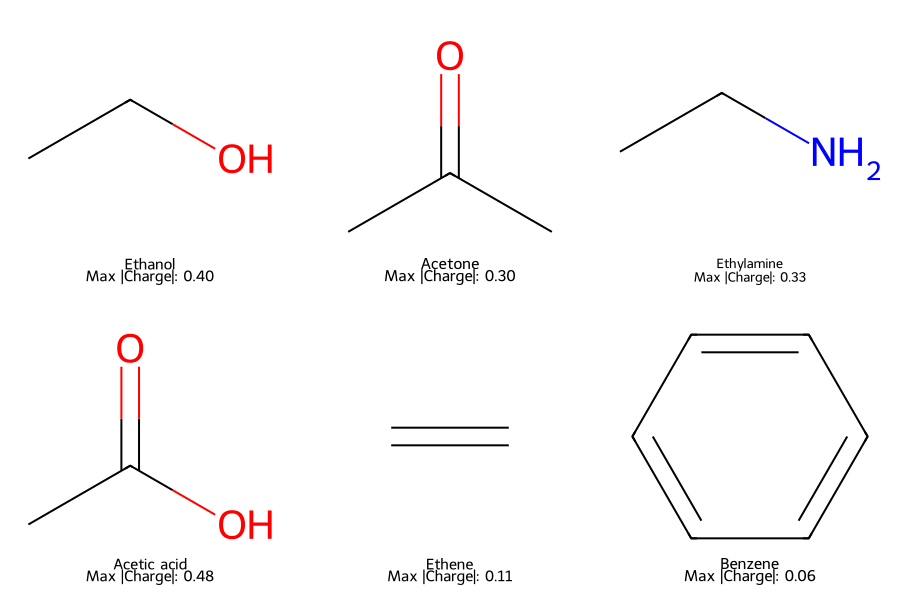

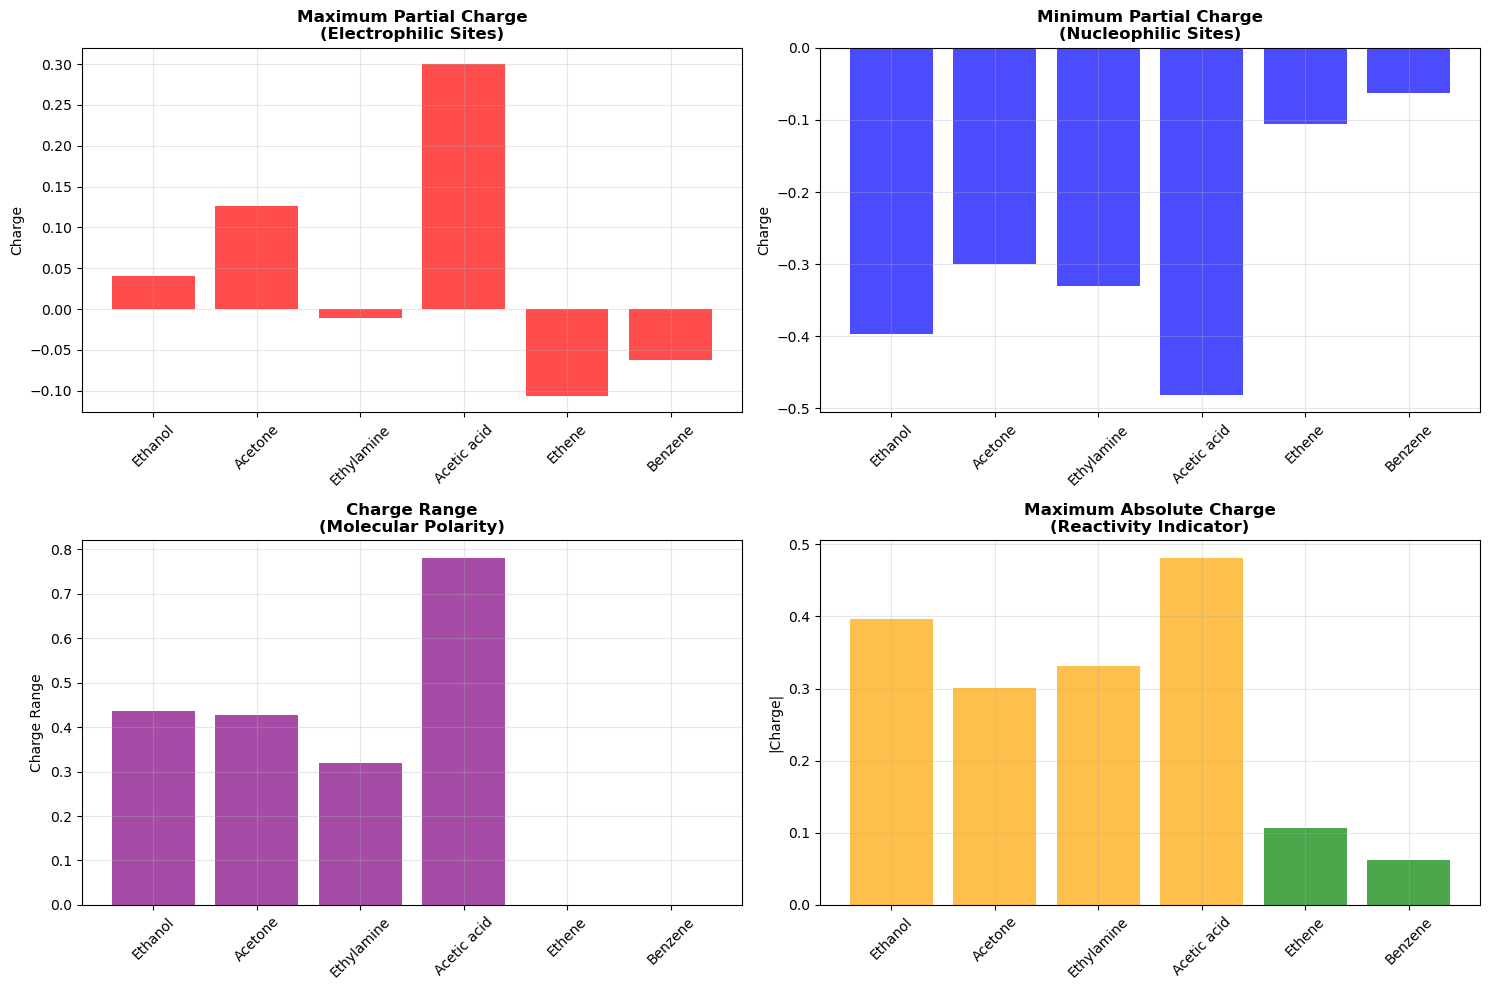

 Charge Descriptor Applications:
----------------------------------------
 MaxPartialCharge: Identifies electrophilic attack sites
 MinPartialCharge: Identifies nucleophilic attack sites
 MaxAbsPartialCharge: Predicts most reactive atoms
 Charge Range: Indicates overall molecular polarity
 Reactivity Assessment:
-------------------------
Ethanol:
  Reactivity: Moderate (max |charge| = 0.397)
  Polarity: Non-polar (charge range = 0.437)
Acetone:
  Reactivity: Moderate (max |charge| = 0.300)
  Polarity: Non-polar (charge range = 0.427)
Ethylamine:
  Reactivity: Moderate (max |charge| = 0.331)
  Polarity: Non-polar (charge range = 0.320)
Acetic acid:
  Reactivity: Moderate (max |charge| = 0.481)
  Polarity: Moderate (charge range = 0.781)
Ethene:
  Reactivity: Low (max |charge| = 0.106)
  Polarity: Non-polar (charge range = 0.000)
Benzene:
  Reactivity: Low (max |charge| = 0.062)
  Polarity: Non-polar (charge range = 0.000)


In [9]:
# Charge & Electrostatic Properties Analysis

# Examples with different charge distributions
charge_examples = [
    "CCO",                    # Alcohol (O is negative)
    "CC(=O)C",                # Ketone (large charge separation)
    "CCN",                    # Amine (N is negative)
    "CC(=O)O",                # Carboxylic acid (very polar)
    "C=C",                     # Alkene (minimal charges)
    "C1=CC=CC=C1",            # Benzene (aromatic)
]

charge_names = ["Ethanol", "Acetone", "Ethylamine", "Acetic acid", "Ethene", "Benzene"]

# if you want to see for previous drug molecules uncommnet the below, it will override with drug molecules 
# charge_examples = list(drug_smiles.values())
# charge_names  = list(drug_smiles.keys())


# Calculate charge descriptors
charge_descriptors = ['MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge']
charge_df = compare_descriptors(charge_examples, charge_descriptors, charge_names)

print("Partial Charge Analysis")
print("=" * 60)
print(charge_df)

# Visualize molecules with charge information
max_charges = [getMolDescriptors(smiles)['MaxAbsPartialCharge'] for smiles in charge_examples]
img = visualize_molecules_with_properties(charge_examples, charge_names, max_charges, "Max |Charge|")
display(img)

# Create charge analysis plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Maximum partial charge (electrophilic sites)
max_pos_charges = [getMolDescriptors(smiles)['MaxPartialCharge'] for smiles in charge_examples]
axes[0,0].bar(charge_names, max_pos_charges, color='red', alpha=0.7)
axes[0,0].set_title('Maximum Partial Charge\n(Electrophilic Sites)', fontweight='bold')
axes[0,0].set_ylabel('Charge')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# Minimum partial charge (nucleophilic sites)
min_neg_charges = [getMolDescriptors(smiles)['MinPartialCharge'] for smiles in charge_examples]
axes[0,1].bar(charge_names, min_neg_charges, color='blue', alpha=0.7)
axes[0,1].set_title('Minimum Partial Charge\n(Nucleophilic Sites)', fontweight='bold')
axes[0,1].set_ylabel('Charge')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

# Charge range (polarity indicator)
charge_ranges = [max_pos - min_neg for max_pos, min_neg in zip(max_pos_charges, min_neg_charges)]
axes[1,0].bar(charge_names, charge_ranges, color='purple', alpha=0.7)
axes[1,0].set_title('Charge Range\n(Molecular Polarity)', fontweight='bold')
axes[1,0].set_ylabel('Charge Range')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

# Maximum absolute charge (reactivity)
reactivity_colors = ['green' if charge < 0.3 else 'orange' if charge < 0.5 else 'red' for charge in max_charges]
axes[1,1].bar(charge_names, max_charges, color=reactivity_colors, alpha=0.7)
axes[1,1].set_title('Maximum Absolute Charge\n(Reactivity Indicator)', fontweight='bold')
axes[1,1].set_ylabel('|Charge|')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(" Charge Descriptor Applications:")
print("-" * 40)
print(" MaxPartialCharge: Identifies electrophilic attack sites")
print(" MinPartialCharge: Identifies nucleophilic attack sites")
print(" MaxAbsPartialCharge: Predicts most reactive atoms")
print(" Charge Range: Indicates overall molecular polarity")

print(" Reactivity Assessment:")
print("-" * 25)
for i, name in enumerate(charge_names):
    reactivity = "Low" if max_charges[i] < 0.3 else "Moderate" if max_charges[i] < 0.5 else "High"
    polarity = "Non-polar" if charge_ranges[i] < 0.5 else "Moderate" if charge_ranges[i] < 1.0 else "Highly polar"
    
    print(f"{name}:")
    print(f"  Reactivity: {reactivity} (max |charge| = {max_charges[i]:.3f})")
    print(f"  Polarity: {polarity} (charge range = {charge_ranges[i]:.3f})")

# EState Descriptors

EState descriptors combine electronic and topological information to characterize atomic environments.

EState (Electrotopological State) Analysis
    Molecule      SMILES  MaxEStateIndex  MinEStateIndex  MaxAbsEStateIndex  MinAbsEStateIndex
     Ethanol         CCO           7.569           0.250              7.569              0.250
     Acetone     CC(=O)C           9.444           0.167              9.444              0.167
     Benzene C1=CC=CC=C1           2.000           2.000              2.000              2.000
  Ethylamine         CCN           4.847           0.750              4.847              0.750
 Acetic acid     CC(=O)O           9.000          -0.833              9.000              0.833
Acetonitrile         C#N           6.500           3.500              6.500              3.500


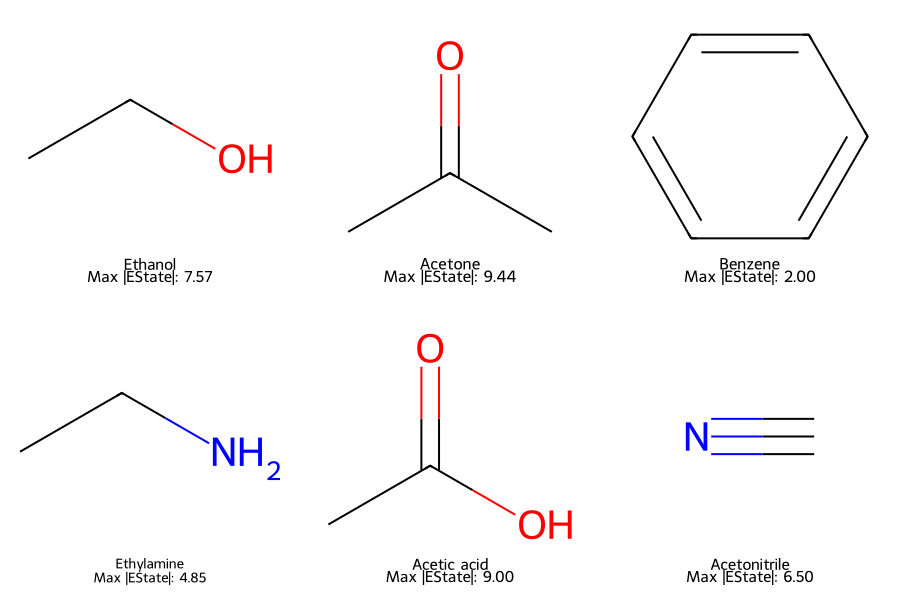

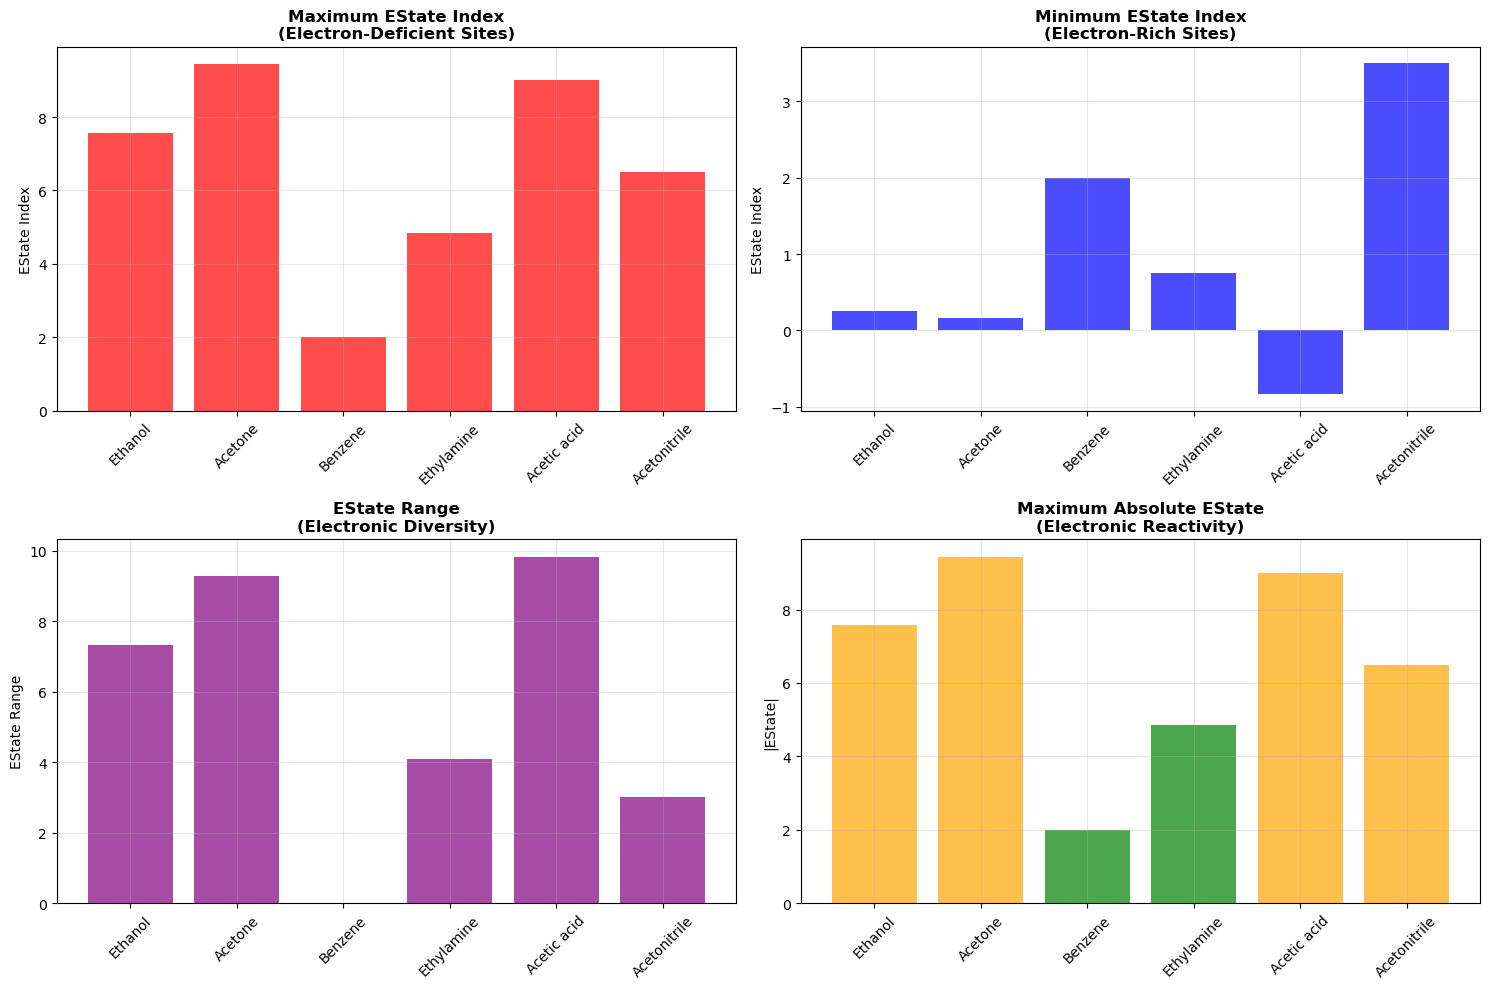

EState Descriptor Applications:
----------------------------------------
MaxEStateIndex: Identifies most electron-deficient atoms (electrophilic sites)
MinEStateIndex: Identifies most electron-rich atoms (nucleophilic sites)
Electronic reactivity: Predicting reaction sites and mechanisms
QSAR modeling: Electronic effects on biological activity
 Electronic Reactivity Assessment:
-----------------------------------
Ethanol:
  Electronic reactivity: Moderate (max |EState| = 7.57)
  Electronic diversity: Moderate (EState range = 7.32)
Acetone:
  Electronic reactivity: Moderate (max |EState| = 9.44)
  Electronic diversity: Moderate (EState range = 9.28)
Benzene:
  Electronic reactivity: Low (max |EState| = 2.00)
  Electronic diversity: Low (EState range = 0.00)
Ethylamine:
  Electronic reactivity: Low (max |EState| = 4.85)
  Electronic diversity: Low (EState range = 4.10)
Acetic acid:
  Electronic reactivity: Moderate (max |EState| = 9.00)
  Electronic diversity: Moderate (EState range = 9.

In [10]:
# Examples with different electronic environments  
estate_examples = [
    "CCO",                                          # Alcohol (O electron-rich)
    "CC(=O)C",                                      # Ketone (C=O electron-deficient)
    "C1=CC=CC=C1",                                  # Benzene (aromatic)
    "CCN",                                          # Amine (N electron-rich)
    "CC(=O)O",                                      # Carboxylic acid (mixed)
    "C#N",                                          # Nitrile (CaN electron-deficient)
]

estate_names = ["Ethanol", "Acetone", "Benzene", "Ethylamine", "Acetic acid", "Acetonitrile"]

# if you want to see for previous drug molecules uncommnet the below, it will override with drug molecules 
# estate_examples = list(drug_smiles.values())
# estate_names  = list(drug_smiles.keys())

# Calculate EState descriptors
estate_descriptors = ['MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex', 'MinAbsEStateIndex']
estate_df = compare_descriptors(estate_examples, estate_descriptors, estate_names)

print("EState (Electrotopological State) Analysis")
print("=" * 60)
print(estate_df.to_string(index=False))

# Visualize molecules with EState values
max_estate = [getMolDescriptors(smiles)['MaxAbsEStateIndex'] for smiles in estate_examples]
img = visualize_molecules_with_properties(estate_examples, estate_names, max_estate, "Max |EState|")
display(img)

# Create EState analysis plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Maximum EState (electron-deficient sites)
max_estate_vals = [getMolDescriptors(smiles)['MaxEStateIndex'] for smiles in estate_examples]
axes[0,0].bar(estate_names, max_estate_vals, color='red', alpha=0.7)
axes[0,0].set_title('Maximum EState Index\n(Electron-Deficient Sites)', fontweight='bold')
axes[0,0].set_ylabel('EState Index')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# Minimum EState (electron-rich sites)
min_estate_vals = [getMolDescriptors(smiles)['MinEStateIndex'] for smiles in estate_examples]
axes[0,1].bar(estate_names, min_estate_vals, color='blue', alpha=0.7)
axes[0,1].set_title('Minimum EState Index\n(Electron-Rich Sites)', fontweight='bold')
axes[0,1].set_ylabel('EState Index')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

# EState range (electronic diversity)
estate_ranges = [max_val - min_val for max_val, min_val in zip(max_estate_vals, min_estate_vals)]
axes[1,0].bar(estate_names, estate_ranges, color='purple', alpha=0.7)
axes[1,0].set_title('EState Range\n(Electronic Diversity)', fontweight='bold')
axes[1,0].set_ylabel('EState Range')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

# Max absolute EState (most reactive)
reactivity_colors = ['green' if estate < 5 else 'orange' if estate < 10 else 'red' for estate in max_estate]
axes[1,1].bar(estate_names, max_estate, color=reactivity_colors, alpha=0.7)
axes[1,1].set_title('Maximum Absolute EState\n(Electronic Reactivity)', fontweight='bold')
axes[1,1].set_ylabel('|EState|')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("EState Descriptor Applications:")
print("-" * 40)
print("MaxEStateIndex: Identifies most electron-deficient atoms (electrophilic sites)")
print("MinEStateIndex: Identifies most electron-rich atoms (nucleophilic sites)")
print("Electronic reactivity: Predicting reaction sites and mechanisms")
print("QSAR modeling: Electronic effects on biological activity")

print(" Electronic Reactivity Assessment:")
print("-" * 35)
for i, name in enumerate(estate_names):
    reactivity = "Low" if max_estate[i] < 5 else "Moderate" if max_estate[i] < 10 else "High"
    diversity = "Low" if estate_ranges[i] < 5 else "Moderate" if estate_ranges[i] < 10 else "High"
    
    print(f"{name}:")
    print(f"  Electronic reactivity: {reactivity} (max |EState| = {max_estate[i]:.2f})")
    print(f"  Electronic diversity: {diversity} (EState range = {estate_ranges[i]:.2f})")

# BCUT Descriptors

BCUT descriptors capture the distribution of various molecular properties across the molecular graph.

BCUT (Burden-CAS-University of Texas) Analysis
      Molecule                   SMILES  BCUT2D_MWHI  BCUT2D_MWLOW  BCUT2D_CHGHI  BCUT2D_CHGLO  BCUT2D_LOGPHI  BCUT2D_LOGPLOW  BCUT2D_MRHI  BCUT2D_MRLOW
      n-Hexane                   CCCCCC       13.816        10.210         1.749        -1.857          1.949          -1.657        4.308         0.702
    Neopentane                CC(C)(C)C       14.013        10.012         1.951        -2.049          2.075          -1.928        4.470         0.469
       Benzene              C1=CC=CC=C1       13.647        10.379         1.574        -1.694          1.794          -1.474        4.986         1.718
       Ethanol                      CCO       16.249        10.908         1.340        -1.522          1.296          -1.568        3.836         0.318
       Aspirin CC(=O)OC1=CC=CC=C1C(=O)O       16.536        10.182         2.104        -2.031          2.170          -2.063        5.913        -0.131
Palmitic chain         CCCCCCCCCCCC

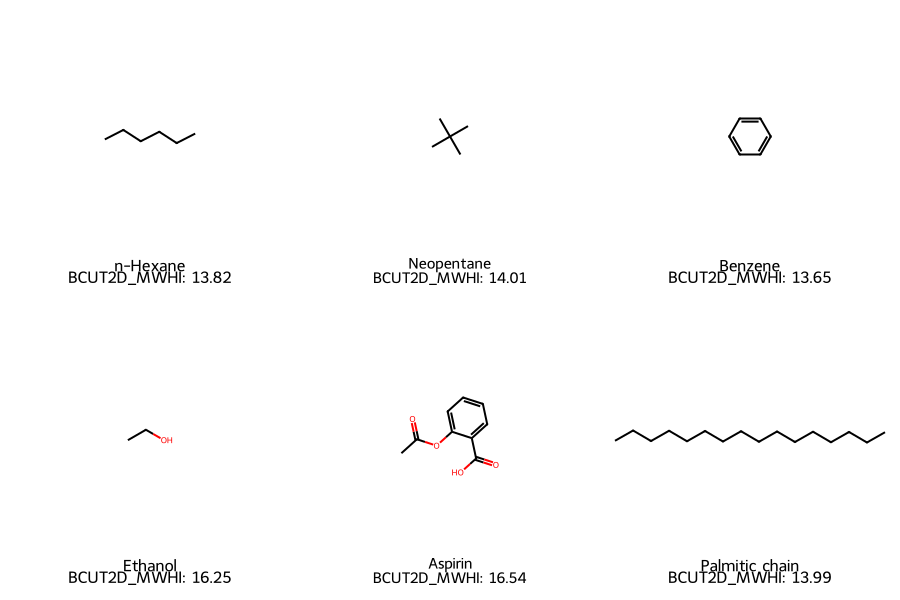

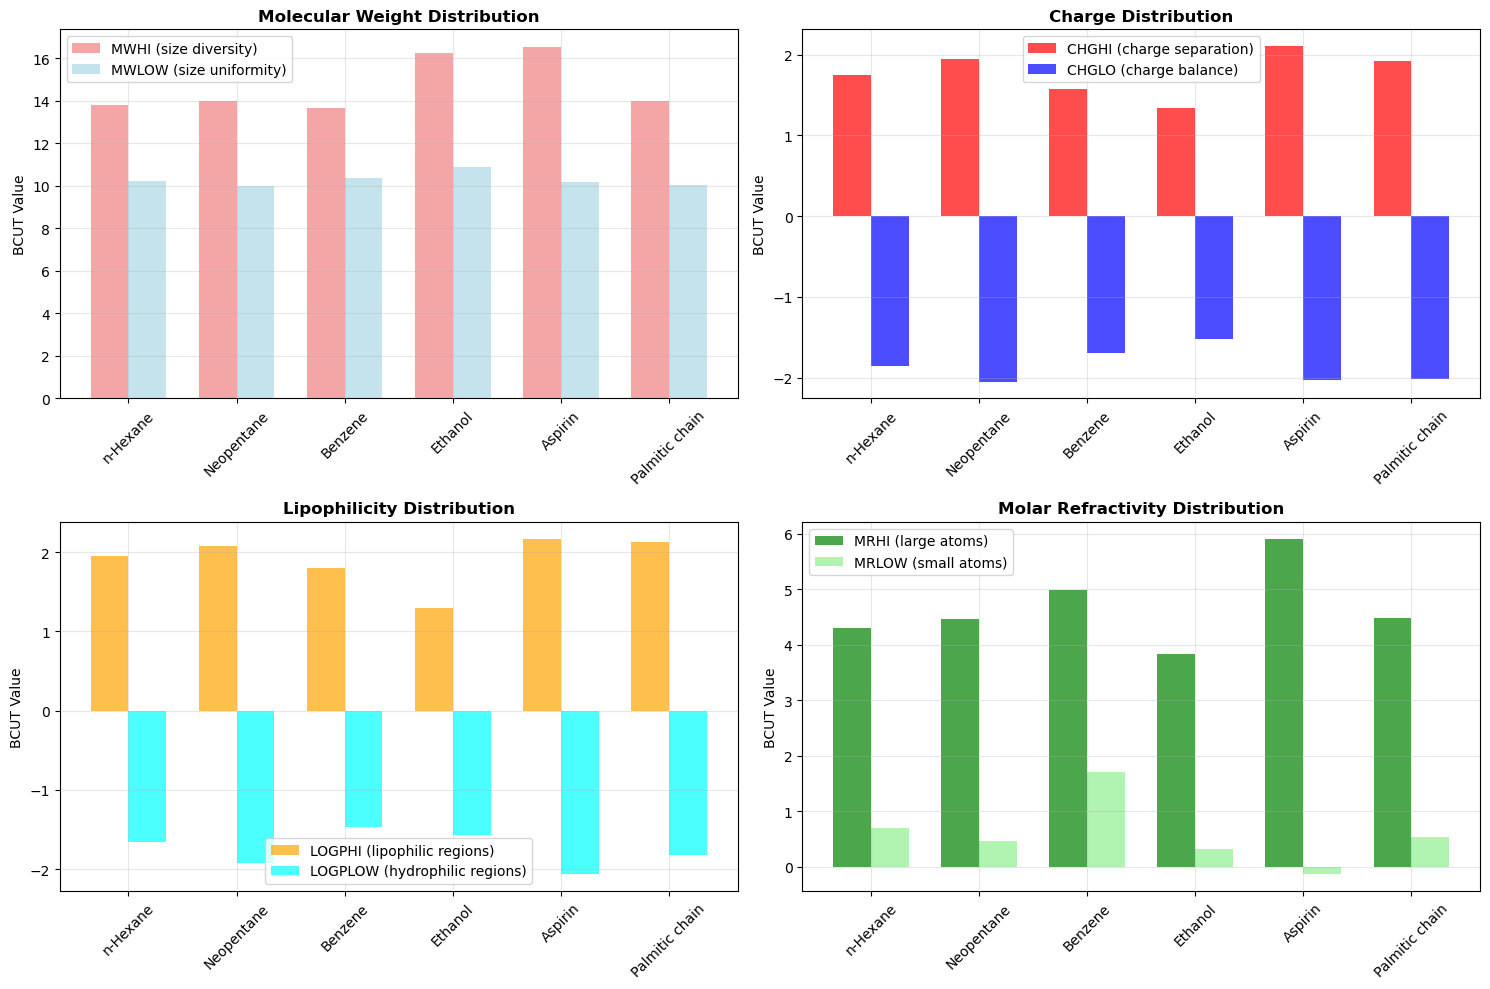

 BCUT Descriptor Applications:
----------------------------------------
 Property distribution: How molecular properties are spread across the structure
 Diversity analysis: Distinguishing molecules with similar overall but different local properties
 QSAR modeling: Capturing distribution effects on biological activity
 Virtual screening: Filtering based on property distribution patterns
 Distribution Pattern Assessment:
----------------------------------------
n-Hexane:
  Size diversity: High (MW range = 3.61)
  Charge separation: High (Charge range = 3.606)
Neopentane:
  Size diversity: High (MW range = 4.00)
  Charge separation: High (Charge range = 4.000)
Benzene:
  Size diversity: High (MW range = 3.27)
  Charge separation: High (Charge range = 3.268)
Ethanol:
  Size diversity: High (MW range = 5.34)
  Charge separation: High (Charge range = 2.863)
Aspirin:
  Size diversity: High (MW range = 6.35)
  Charge separation: High (Charge range = 4.135)
Palmitic chain:
  Size diversity: H

In [11]:
# BCUT (Burden-CAS-University of Texas) Analysis

# Examples with different property distributions
bcut_examples = [
    "CCCCCC",                                       # Linear (uniform distribution)
    "CC(C)(C)C",                                    # Highly branched (non-uniform)
    "C1=CC=CC=C1",                                  # Aromatic (symmetric)
    "CCO",                                          # Polar (charge separation)
    "CC(=O)OC1=CC=CC=C1C(=O)O",                     # Aspirin (mixed properties)
    "CCCCCCCCCCCCCCCC",                            # Long chain (extreme distribution)
]

bcut_names = ["n-Hexane", "Neopentane", "Benzene", "Ethanol", "Aspirin", "Palmitic chain"]
# if you want to see for previous drug molecules uncommnet the below, it will override with drug molecules 
# bcut_examples = list(drug_smiles.values())
# bcut_names  = list(drug_smiles.keys())


# Calculate BCUT descriptors  
bcut_descriptors = ['BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 
                   'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW']
bcut_df = compare_descriptors(bcut_examples, bcut_descriptors, bcut_names)

print("BCUT (Burden-CAS-University of Texas) Analysis")
print("=" * 60)
print(bcut_df.to_string(index=False))

# Visualize molecules with BCUT values
mw_hi_vals = [getMolDescriptors(smiles)['BCUT2D_MWHI'] for smiles in bcut_examples]
img = visualize_molecules_with_properties(bcut_examples, bcut_names, mw_hi_vals, "BCUT2D_MWHI")
display(img)

# Create BCUT analysis plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Molecular weight distribution
mw_low_vals = [getMolDescriptors(smiles)['BCUT2D_MWLOW'] for smiles in bcut_examples]
width = 0.35
x = np.arange(len(bcut_names))
axes[0,0].bar(x - width/2, mw_hi_vals, width, label='MWHI (size diversity)', alpha=0.7, color='lightcoral')
axes[0,0].bar(x + width/2, mw_low_vals, width, label='MWLOW (size uniformity)', alpha=0.7, color='lightblue')
axes[0,0].set_title('Molecular Weight Distribution', fontweight='bold')
axes[0,0].set_ylabel('BCUT Value')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(bcut_names, rotation=45)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Charge distribution
chg_hi_vals = [getMolDescriptors(smiles)['BCUT2D_CHGHI'] for smiles in bcut_examples]
chg_low_vals = [getMolDescriptors(smiles)['BCUT2D_CHGLO'] for smiles in bcut_examples]
axes[0,1].bar(x - width/2, chg_hi_vals, width, label='CHGHI (charge separation)', alpha=0.7, color='red')
axes[0,1].bar(x + width/2, chg_low_vals, width, label='CHGLO (charge balance)', alpha=0.7, color='blue')
axes[0,1].set_title('Charge Distribution', fontweight='bold')
axes[0,1].set_ylabel('BCUT Value')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(bcut_names, rotation=45)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# LogP distribution
logp_hi_vals = [getMolDescriptors(smiles)['BCUT2D_LOGPHI'] for smiles in bcut_examples]
logp_low_vals = [getMolDescriptors(smiles)['BCUT2D_LOGPLOW'] for smiles in bcut_examples]
axes[1,0].bar(x - width/2, logp_hi_vals, width, label='LOGPHI (lipophilic regions)', alpha=0.7, color='orange')
axes[1,0].bar(x + width/2, logp_low_vals, width, label='LOGPLOW (hydrophilic regions)', alpha=0.7, color='cyan')
axes[1,0].set_title('Lipophilicity Distribution', fontweight='bold')
axes[1,0].set_ylabel('BCUT Value')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(bcut_names, rotation=45)
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Molar refractivity distribution
mr_hi_vals = [getMolDescriptors(smiles)['BCUT2D_MRHI'] for smiles in bcut_examples]
mr_low_vals = [getMolDescriptors(smiles)['BCUT2D_MRLOW'] for smiles in bcut_examples]
axes[1,1].bar(x - width/2, mr_hi_vals, width, label='MRHI (large atoms)', alpha=0.7, color='green')
axes[1,1].bar(x + width/2, mr_low_vals, width, label='MRLOW (small atoms)', alpha=0.7, color='lightgreen')
axes[1,1].set_title('Molar Refractivity Distribution', fontweight='bold')
axes[1,1].set_ylabel('BCUT Value')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(bcut_names, rotation=45)
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(" BCUT Descriptor Applications:")
print("-" * 40)
print(" Property distribution: How molecular properties are spread across the structure")
print(" Diversity analysis: Distinguishing molecules with similar overall but different local properties")
print(" QSAR modeling: Capturing distribution effects on biological activity")
print(" Virtual screening: Filtering based on property distribution patterns")

print(" Distribution Pattern Assessment:")
print("-" * 40)
for i, name in enumerate(bcut_names):
    mw_diversity = "High" if (mw_hi_vals[i] - mw_low_vals[i]) > 1 else "Moderate" if (mw_hi_vals[i] - mw_low_vals[i]) > 0.5 else "Low"
    charge_separation = "High" if (chg_hi_vals[i] - chg_low_vals[i]) > 0.1 else "Moderate" if (chg_hi_vals[i] - chg_low_vals[i]) > 0.05 else "Low"
    
    print(f"{name}:")
    print(f"  Size diversity: {mw_diversity} (MW range = {mw_hi_vals[i] - mw_low_vals[i]:.2f})")
    print(f"  Charge separation: {charge_separation} (Charge range = {chg_hi_vals[i] - chg_low_vals[i]:.3f})")

# Topological Descriptors

Topological descriptors capture molecular connectivity, complexity, and shape information without requiring 3D coordinates.

= Topological Descriptors Analysis
              Molecule                                             SMILES  \
0          Futibatinib  COC1=CC(=CC(=C1)C#CC2=NN(C3=NC=NC(=C23)N)[C@H]...   
1         Infigratinib  CCN1CCN(CC1)C2=CC=C(C=C2)NC3=CC(=NC=N3)N(C)C(=...   
2          Pemigatinib  CCN1C2=C3C=C(NC3=NC=C2CN(C1=O)C4=C(C(=CC(=C4F)...   
3           Paclitaxel  CC1=C2[C@H](C(=O)[C@@]3([C@H](C[C@@H]4[C@]([C@...   
4          Erdafitinib  CC(C)NCCN(C1=CC2=NC(=CN=C2C=C1)C3=CN(N=C3)C)C4...   
5   Diethylstilbestrol        CC/C(=C(/CC)\C1=CC=C(C=C1)O)/C2=CC=C(C=C2)O   
6            Histamine                                     C1=C(NC=N1)CCN   
7             Imatinib  CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C...   
8         Progesterone  CC(=O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2CCC4...   
9             Cysteine                                C([C@@H](C(=O)O)N)S   
10         Thalidomide             C1CC(=O)NC(=O)C1N2C(=O)C3=CC=CC=C3C2=O   
11           Melphalan           C1=CC(=

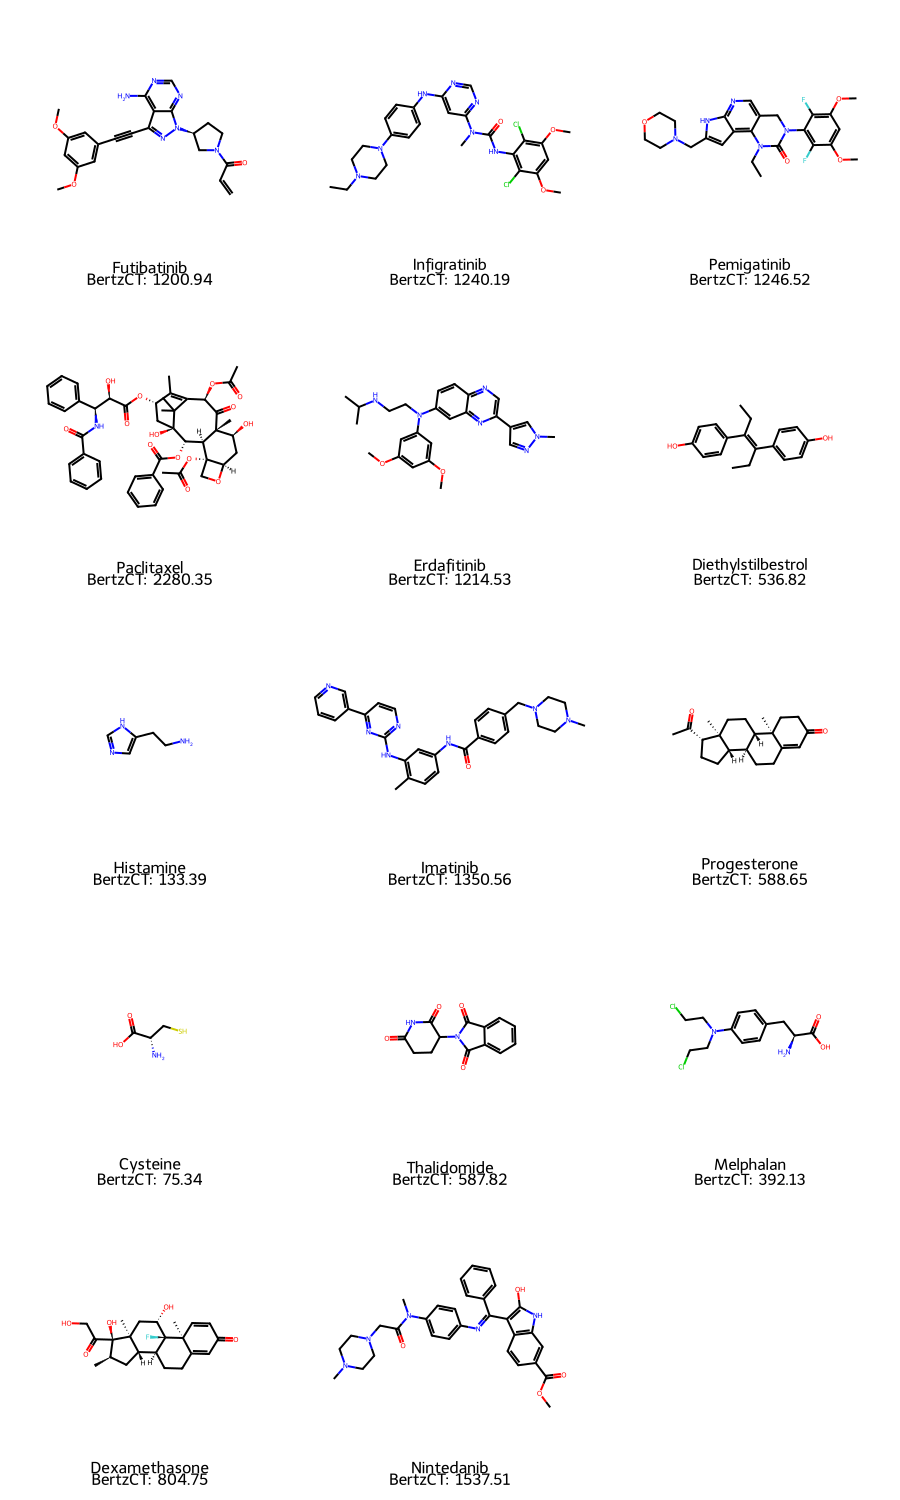

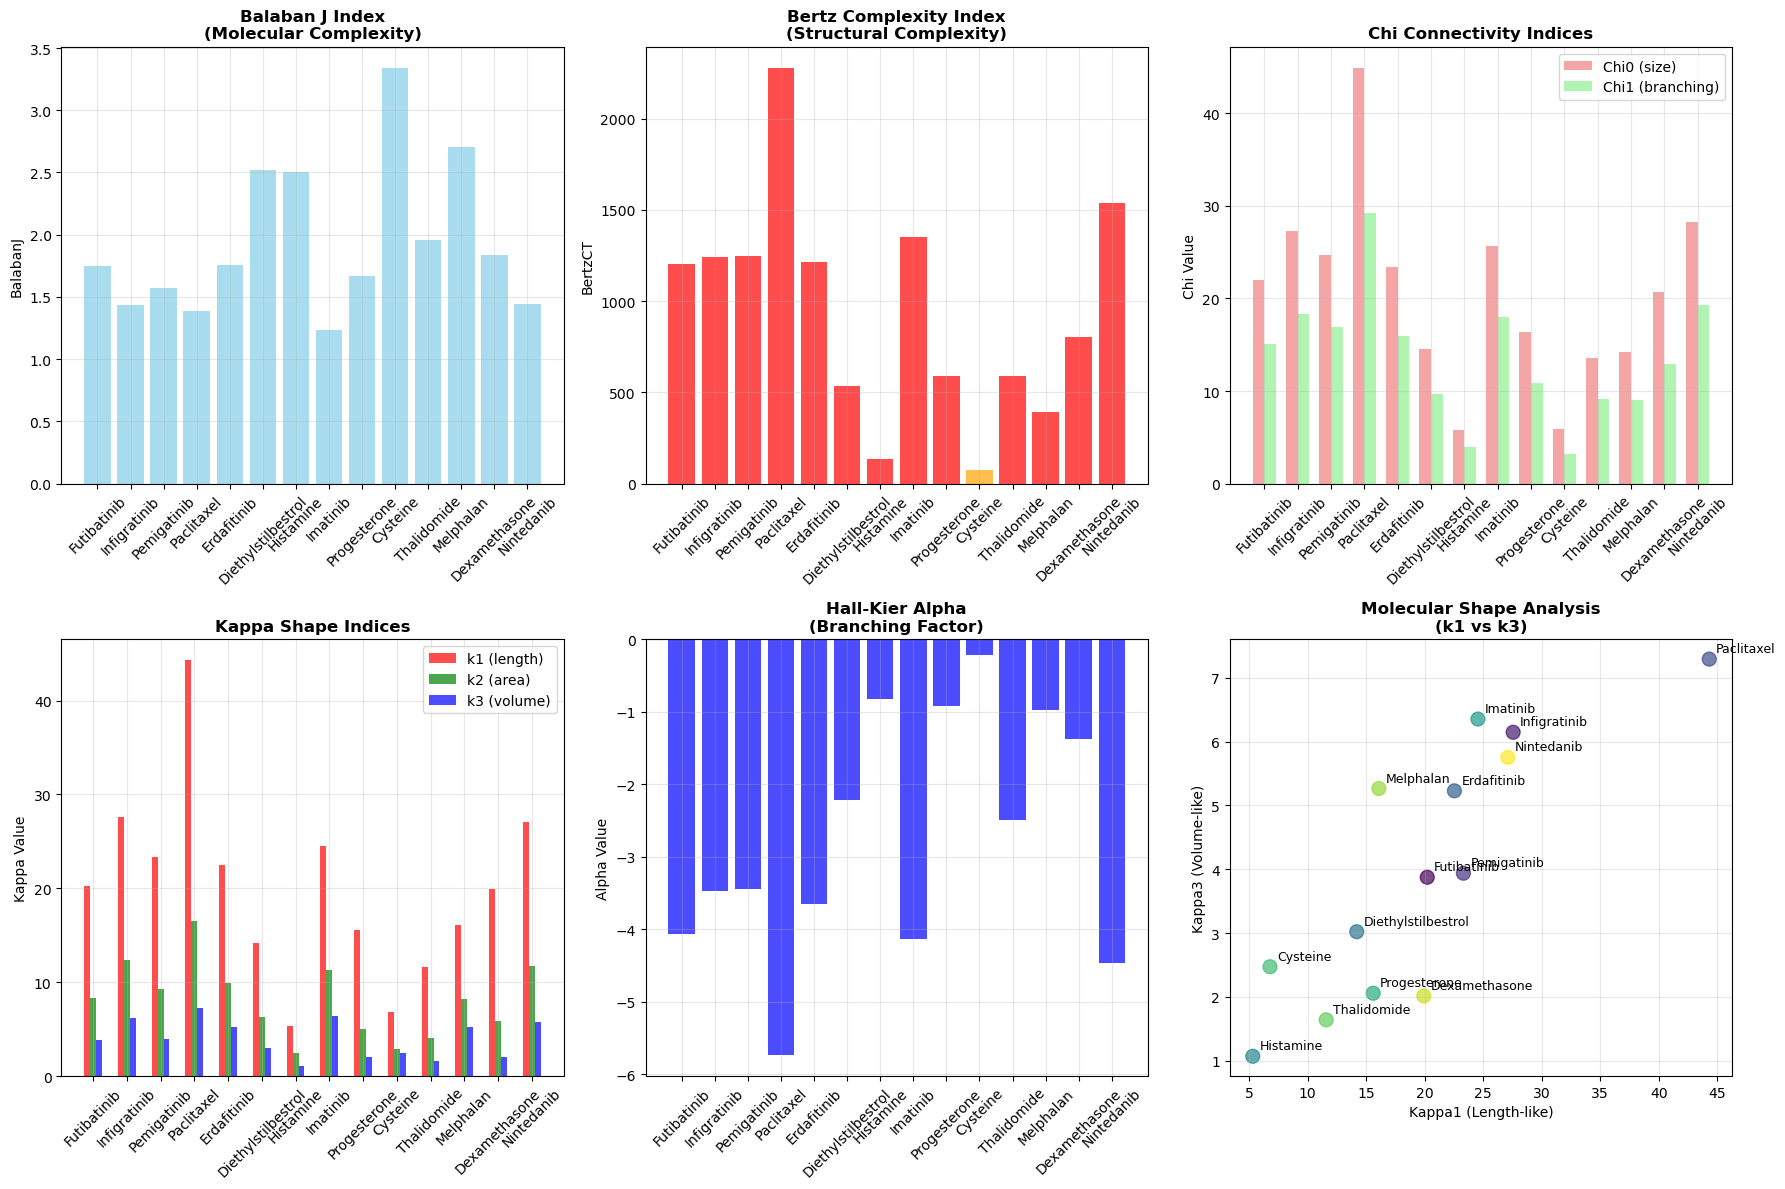


= Topological Descriptor Applications:
---------------------------------------------
 BalabanJ: Overall molecular complexity and branching
 BertzCT: Structural complexity with heteroatom weighting
 Chi indices: Connectivity patterns and molecular size
 Kappa indices: 3D molecular shape without coordinates
 HallKierAlpha: Degree of branching (negative = more branched)
----------------------------------------

Futibatinib:
  Shape: = Rod-like (linear)
  Branching: Highly branched ( = -4.06)
  Complexity: Complex (Bertz = 1200.9)

Infigratinib:
  Shape: = Rod-like (linear)
  Branching: Highly branched ( = -3.47)
  Complexity: Complex (Bertz = 1240.2)

Pemigatinib:
  Shape: = Rod-like (linear)
  Branching: Highly branched ( = -3.44)
  Complexity: Complex (Bertz = 1246.5)

Paclitaxel:
  Shape: = Rod-like (linear)
  Branching: Highly branched ( = -5.74)
  Complexity: Complex (Bertz = 2280.3)

Erdafitinib:
  Shape: =6 Intermediate shape
  Branching: Highly branched ( = -3.65)
  Complexity: C

In [12]:
# Topological Descriptors Analysis

# Examples showing different topological features
topo_examples = [
    "CCCCCC",                              # Linear hexane
    "CC(C)C(C)C",                         # Branched isohexane
    "C1CCCCC1",                           # Cyclohexane (ring)
    "C1=CC=CC=C1",                        # Benzene (aromatic)
    "C1CCC2CCCCC2C1",                     # Decalin (bicyclic)
    "CC1=C(C=C(C=C1)[N+](=O)[O-])C",      # Complex aromatic
]

topo_names = ["n-Hexane", "Isohexane", "Cyclohexane", "Benzene", "Decalin", "Nitrotoluene"]
# if you want to see for previous drug molecules uncommnet the below, it will override with drug molecules 
topo_examples = list(drug_smiles.values())
topo_names  = list(drug_smiles.keys())


# Calculate key topological descriptors
topo_descriptors = ['BalabanJ', 'BertzCT', 'Chi0', 'Chi1', 'Kappa1', 'Kappa2', 'Kappa3', 'HallKierAlpha']
topo_df = compare_descriptors(topo_examples, topo_descriptors, topo_names)

print("= Topological Descriptors Analysis")
print("=" * 70)
print(topo_df)

# Visualize molecules
bertz_values = [getMolDescriptors(smiles)['BertzCT'] for smiles in topo_examples]
img = visualize_molecules_with_properties(topo_examples, topo_names, bertz_values, "BertzCT")
display(img)

# Comprehensive topological analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Balaban J (complexity)
balaban_values = [getMolDescriptors(smiles)['BalabanJ'] for smiles in topo_examples]
axes[0,0].bar(topo_names, balaban_values, color='skyblue', alpha=0.7)
axes[0,0].set_title('Balaban J Index\n(Molecular Complexity)', fontweight='bold')
axes[0,0].set_ylabel('BalabanJ')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# Bertz Complexity
bertz_colors = ['green' if b < 50 else 'orange' if b < 100 else 'red' for b in bertz_values]
axes[0,1].bar(topo_names, bertz_values, color=bertz_colors, alpha=0.7)
axes[0,1].set_title('Bertz Complexity Index\n(Structural Complexity)', fontweight='bold')
axes[0,1].set_ylabel('BertzCT')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

# Chi connectivity indices
chi0_values = [getMolDescriptors(smiles)['Chi0'] for smiles in topo_examples]
chi1_values = [getMolDescriptors(smiles)['Chi1'] for smiles in topo_examples]

width = 0.35
x = np.arange(len(topo_names))
axes[0,2].bar(x - width/2, chi0_values, width, label='Chi0 (size)', alpha=0.7, color='lightcoral')
axes[0,2].bar(x + width/2, chi1_values, width, label='Chi1 (branching)', alpha=0.7, color='lightgreen')
axes[0,2].set_title('Chi Connectivity Indices', fontweight='bold')
axes[0,2].set_ylabel('Chi Value')
axes[0,2].set_xticks(x)
axes[0,2].set_xticklabels(topo_names, rotation=45)
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# Kappa shape indices
kappa1_values = [getMolDescriptors(smiles)['Kappa1'] for smiles in topo_examples]
kappa2_values = [getMolDescriptors(smiles)['Kappa2'] for smiles in topo_examples]
kappa3_values = [getMolDescriptors(smiles)['Kappa3'] for smiles in topo_examples]

axes[1,0].bar(x - width/2, kappa1_values, width/2, label='k1 (length)', alpha=0.7, color='red')
axes[1,0].bar(x, kappa2_values, width/2, label='k2 (area)', alpha=0.7, color='green')
axes[1,0].bar(x + width/2, kappa3_values, width/2, label='k3 (volume)', alpha=0.7, color='blue')
axes[1,0].set_title('Kappa Shape Indices', fontweight='bold')
axes[1,0].set_ylabel('Kappa Value')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(topo_names, rotation=45)
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Hall-Kier Alpha (branching correction)
alpha_values = [getMolDescriptors(smiles)['HallKierAlpha'] for smiles in topo_examples]
alpha_colors = ['blue' if a < 0 else 'green' for a in alpha_values]
axes[1,1].bar(topo_names, alpha_values, color=alpha_colors, alpha=0.7)
axes[1,1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
axes[1,1].set_title('Hall-Kier Alpha\n(Branching Factor)', fontweight='bold')
axes[1,1].set_ylabel('Alpha Value')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

# Shape analysis (Kappa ratios)
shape_ratios = [k1/k3 if k3 > 0 else 0 for k1, k3 in zip(kappa1_values, kappa3_values)]
axes[1,2].scatter(kappa1_values, kappa3_values, s=100, alpha=0.7, c=range(len(topo_names)), cmap='viridis')
for i, name in enumerate(topo_names):
    axes[1,2].annotate(name, (kappa1_values[i], kappa3_values[i]), 
                      xytext=(5, 5), textcoords='offset points', fontsize=9)
axes[1,2].set_xlabel('Kappa1 (Length-like)')
axes[1,2].set_ylabel('Kappa3 (Volume-like)')
axes[1,2].set_title('Molecular Shape Analysis\n(k1 vs k3)', fontweight='bold')
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n= Topological Descriptor Applications:")
print("-" * 45)
print(" BalabanJ: Overall molecular complexity and branching")
print(" BertzCT: Structural complexity with heteroatom weighting") 
print(" Chi indices: Connectivity patterns and molecular size")
print(" Kappa indices: 3D molecular shape without coordinates")
print(" HallKierAlpha: Degree of branching (negative = more branched)")
print("-" * 40)
for i, name in enumerate(topo_names):
    k1, k2, k3 = kappa1_values[i], kappa2_values[i], kappa3_values[i]
    
    # Shape classification based on kappa ratios
    if k1 > 2*k2 and k2 > 2*k3:
        shape = "= Rod-like (linear)"
    elif k1 > k2 and k2 > 2*k3:
        shape = "=Disc-like (planar)"
    elif abs(k1 - k2) < 0.5 and abs(k2 - k3) < 0.5:
        shape = "Spherical (compact)"
    else:
        shape = "=6 Intermediate shape"
    
    branching = "Highly branched" if alpha_values[i] < -0.5 else "Moderately branched" if alpha_values[i] < 0 else "Linear/unbranched"
    complexity = "Simple" if bertz_values[i] < 20 else "Moderate" if bertz_values[i] < 50 else "Complex"
    
    print(f"\n{name}:")
    print(f"  Shape: {shape}")
    print(f"  Branching: {branching} ( = {alpha_values[i]:.2f})")
    print(f"  Complexity: {complexity} (Bertz = {bertz_values[i]:.1f})")

# Structural Count Descriptors

These descriptors count specific structural features and are essential for drug design, particularly Lipinski's Rule of Five analysis.

 Lipinski's Rule of Five Analysis
              Molecule                                             SMILES  \
0          Futibatinib  COC1=CC(=CC(=C1)C#CC2=NN(C3=NC=NC(=C23)N)[C@H]...   
1         Infigratinib  CCN1CCN(CC1)C2=CC=C(C=C2)NC3=CC(=NC=N3)N(C)C(=...   
2          Pemigatinib  CCN1C2=C3C=C(NC3=NC=C2CN(C1=O)C4=C(C(=CC(=C4F)...   
3           Paclitaxel  CC1=C2[C@H](C(=O)[C@@]3([C@H](C[C@@H]4[C@]([C@...   
4          Erdafitinib  CC(C)NCCN(C1=CC2=NC(=CN=C2C=C1)C3=CN(N=C3)C)C4...   
5   Diethylstilbestrol        CC/C(=C(/CC)\C1=CC=C(C=C1)O)/C2=CC=C(C=C2)O   
6            Histamine                                     C1=C(NC=N1)CCN   
7             Imatinib  CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C...   
8         Progesterone  CC(=O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2CCC4...   
9             Cysteine                                C([C@@H](C(=O)O)N)S   
10         Thalidomide             C1CC(=O)NC(=O)C1N2C(=O)C3=CC=CC=C3C2=O   
11           Melphalan           C1=CC(=CC

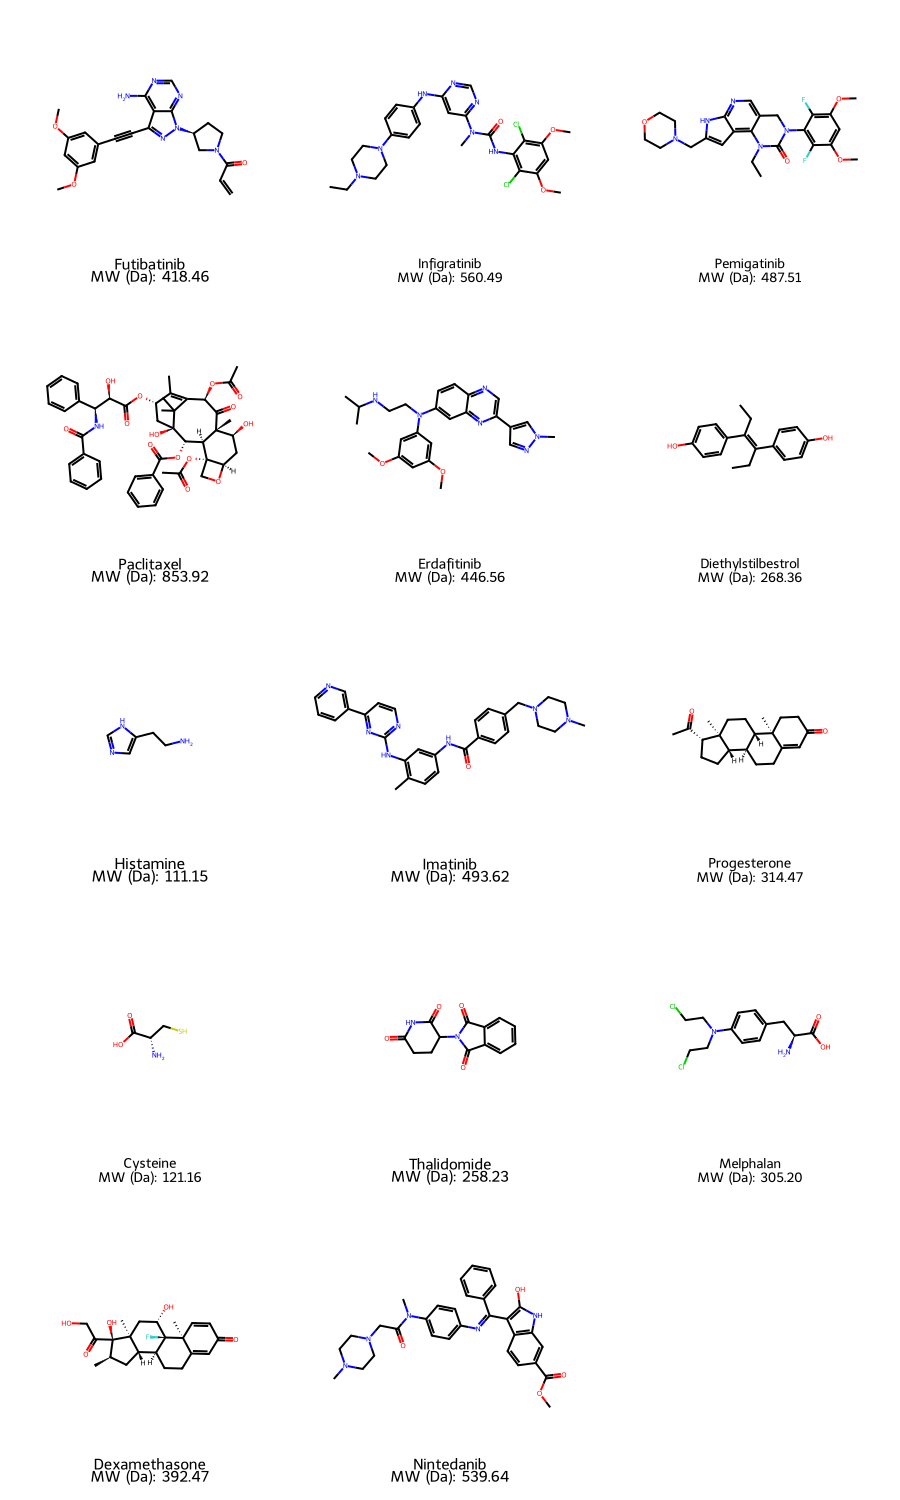

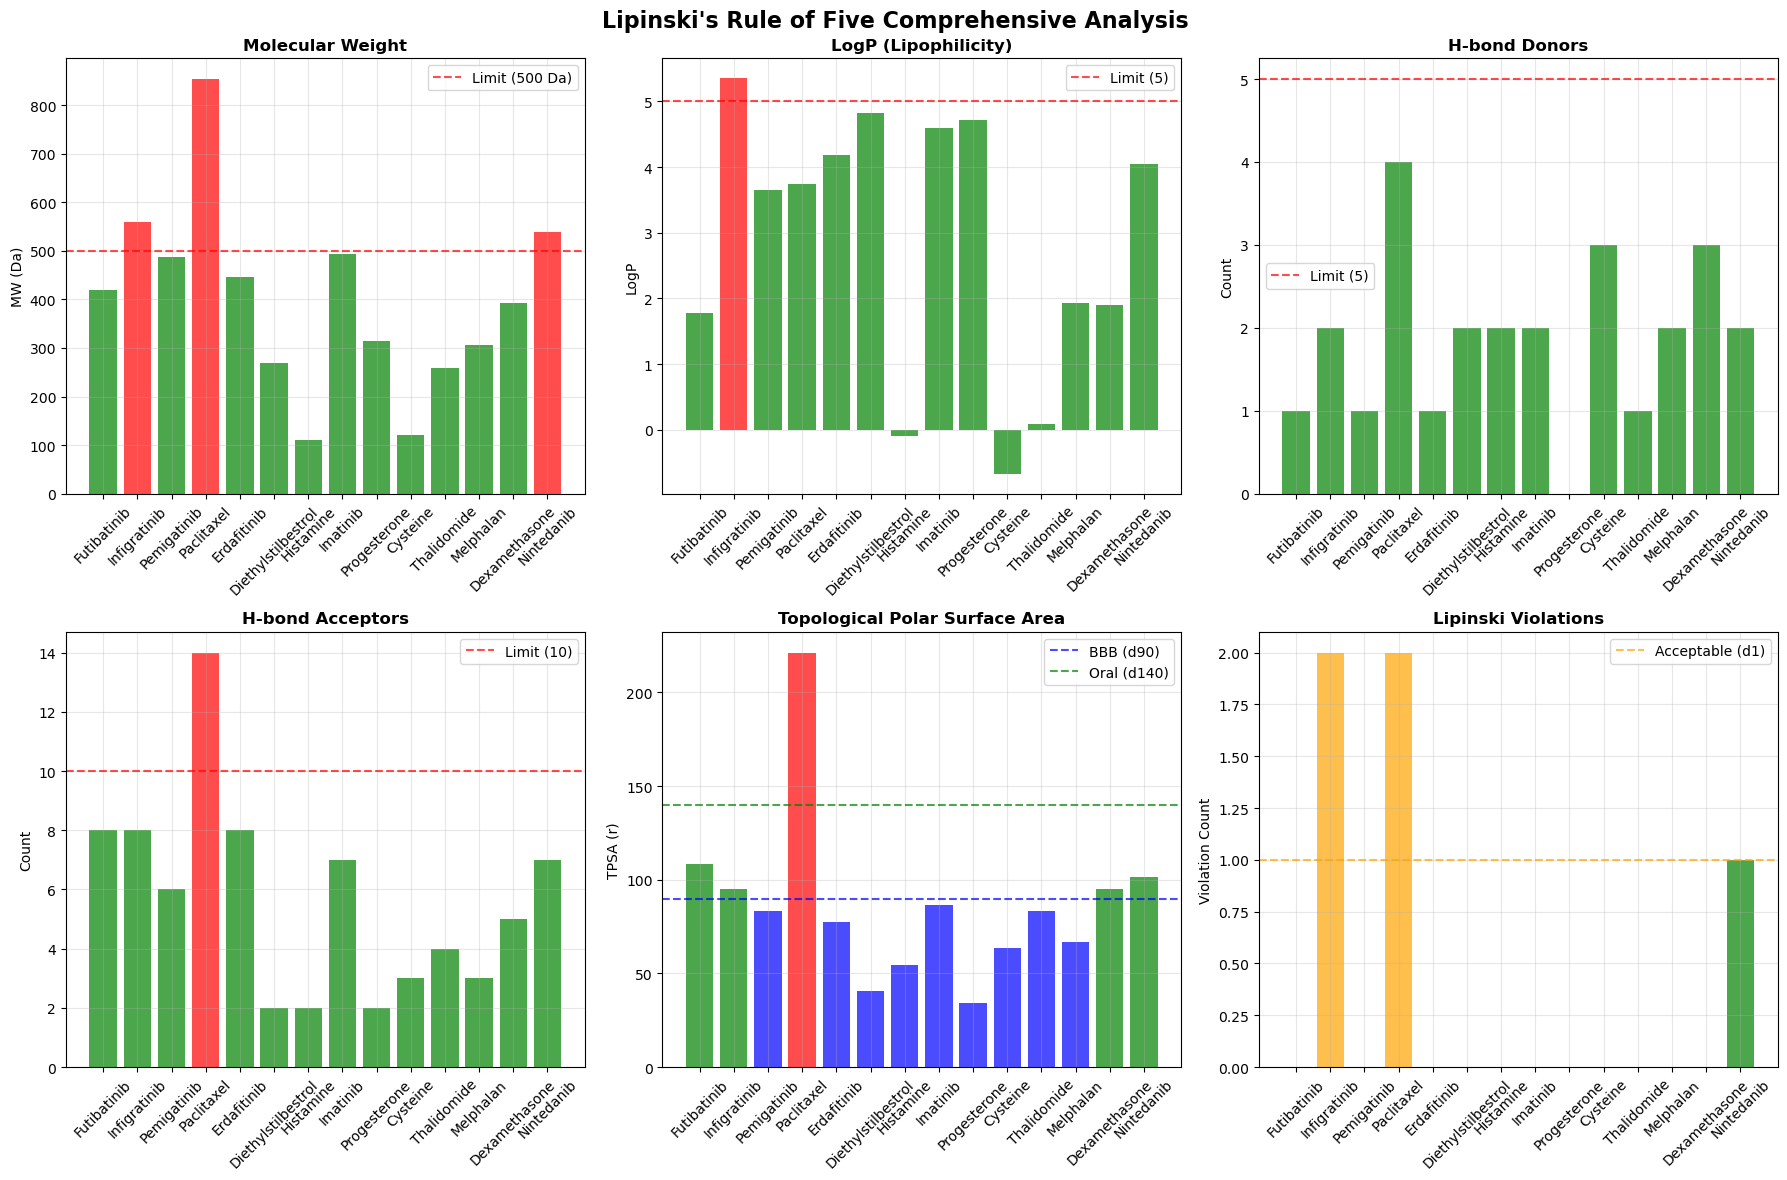


Comprehensive Drug-likeness Assessment
Lipinski's Rule of Five Criteria:
 Molecular Weight d 500 Da
 LogP d 5
 H-bond Donors d 5
 H-bond Acceptors d 10
 Violations d 1 (acceptable)
Additional Modern Criteria:
 TPSA d 140 r (oral bioavailability)
 TPSA d 90 r (blood-brain barrier)
 FractionCSP3 e 0.5 (3D character)
 Rotatable Bonds d 10 (flexibility)
 Individual Assessments:
----------------------------------------

Futibatinib:
  Score: 5/6 criteria met (MW, LogP, HBD, HBA, TPSA)
  Lipinski violations: 0/4
  Assessment:  Excellent drug-likeness
  Permeability: Orally available (TPSA: 108.4 r)

Infigratinib:
  Score: 3/6 criteria met (HBD, HBA, TPSA)
  Lipinski violations: 2/4
  Assessment: Moderate drug-likeness
  Permeability: Orally available (TPSA: 95.1 r)

Pemigatinib:
  Score: 5/6 criteria met (MW, LogP, HBD, HBA, TPSA)
  Lipinski violations: 0/4
  Assessment:  Excellent drug-likeness
  Permeability: BBB permeable (TPSA: 83.2 r)

Paclitaxel:
  Score: 2/6 criteria met (LogP, HBD)


In [13]:
# Structural Count Descriptors Analysis

# Examples showcasing different structural features
structural_examples = [
    "CCO",                                    # Simple alcohol
    "CC(C)(C)C",                             # Highly branched (high sp3)
    "C1=CC=CC=C1",                          # Benzene (aromatic, no sp3)
    "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O",         # Ibuprofen (drug-like)
    "CCO[C@H]1C[C@H](CC[C@@H]1O)O",          # Complex with stereocenters
    "CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C)C",  # Complex drug
]

structural_names = ["Ethanol", "Neopentane", "Benzene", "Ibuprofen", "Sugar analog", "Complex drug"]

# if you want to see for previous drug molecules uncommnet the below, it will override with drug molecules 
structural_examples = list(drug_smiles.values())
structural_names   = list(drug_smiles.keys())

# Lipinski's Rule of Five descriptors
lipinski_descriptors = ['MolWt', 'MolLogP', 'NumHDonors', 'NumHAcceptors', 'NumRotatableBonds']
lipinski_df = compare_descriptors(structural_examples, lipinski_descriptors, structural_names)

print(" Lipinski's Rule of Five Analysis")
print("=" * 70)
print(lipinski_df)

# Additional structural descriptors
structural_descriptors = ['HeavyAtomCount', 'FractionCSP3', 'RingCount', 'NumAromaticRings', 'NumAtomStereoCenters', 'TPSA']
structural_df = compare_descriptors(structural_examples, structural_descriptors, structural_names)

print(" Additional Structural Features")
print("=" * 70)
print(structural_df.to_string(index=False))

# Visualize molecules
mw_values = [getMolDescriptors(smiles)['MolWt'] for smiles in structural_examples]
img = visualize_molecules_with_properties(structural_examples, structural_names, mw_values, "MW (Da)")
display(img)

# Comprehensive Lipinski analysis dashboard
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Molecular Weight
mw_vals = [getMolDescriptors(smiles)['MolWt'] for smiles in structural_examples]
colors_mw = ['green' if mw <= 500 else 'red' for mw in mw_vals]
axes[0,0].bar(structural_names, mw_vals, color=colors_mw, alpha=0.7)
axes[0,0].axhline(y=500, color='red', linestyle='--', alpha=0.7, label='Limit (500 Da)')
axes[0,0].set_title('Molecular Weight', fontweight='bold')
axes[0,0].set_ylabel('MW (Da)')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# LogP
logp_vals = [getMolDescriptors(smiles)['MolLogP'] for smiles in structural_examples]
colors_logp = ['green' if logp <= 5 else 'red' for logp in logp_vals]
axes[0,1].bar(structural_names, logp_vals, color=colors_logp, alpha=0.7)
axes[0,1].axhline(y=5, color='red', linestyle='--', alpha=0.7, label='Limit (5)')
axes[0,1].set_title('LogP (Lipophilicity)', fontweight='bold')
axes[0,1].set_ylabel('LogP')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# H-bond Donors
hbd_vals = [getMolDescriptors(smiles)['NumHDonors'] for smiles in structural_examples]
colors_hbd = ['green' if hbd <= 5 else 'red' for hbd in hbd_vals]
axes[0,2].bar(structural_names, hbd_vals, color=colors_hbd, alpha=0.7)
axes[0,2].axhline(y=5, color='red', linestyle='--', alpha=0.7, label='Limit (5)')
axes[0,2].set_title('H-bond Donors', fontweight='bold')
axes[0,2].set_ylabel('Count')
axes[0,2].tick_params(axis='x', rotation=45)
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# H-bond Acceptors
hba_vals = [getMolDescriptors(smiles)['NumHAcceptors'] for smiles in structural_examples]
colors_hba = ['green' if hba <= 10 else 'red' for hba in hba_vals]
axes[1,0].bar(structural_names, hba_vals, color=colors_hba, alpha=0.7)
axes[1,0].axhline(y=10, color='red', linestyle='--', alpha=0.7, label='Limit (10)')
axes[1,0].set_title('H-bond Acceptors', fontweight='bold')
axes[1,0].set_ylabel('Count')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# TPSA (Polar Surface Area)
tpsa_vals = [getMolDescriptors(smiles)['TPSA'] for smiles in structural_examples]
colors_tpsa = ['blue' if tpsa <= 90 else 'green' if tpsa <= 140 else 'red' for tpsa in tpsa_vals]
axes[1,1].bar(structural_names, tpsa_vals, color=colors_tpsa, alpha=0.7)
axes[1,1].axhline(y=90, color='blue', linestyle='--', alpha=0.7, label='BBB (d90)')
axes[1,1].axhline(y=140, color='green', linestyle='--', alpha=0.7, label='Oral (d140)')
axes[1,1].set_title('Topological Polar Surface Area', fontweight='bold')
axes[1,1].set_ylabel('TPSA (r)')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# Lipinski Violations Summary
violations = []
for i in range(len(structural_examples)):
    viol_count = 0
    if mw_vals[i] > 500: viol_count += 1
    if logp_vals[i] > 5: viol_count += 1
    if hbd_vals[i] > 5: viol_count += 1
    if hba_vals[i] > 10: viol_count += 1
    violations.append(viol_count)

colors_viol = ['green' if v <= 1 else 'orange' if v == 2 else 'red' for v in violations]
axes[1,2].bar(structural_names, violations, color=colors_viol, alpha=0.7)
axes[1,2].axhline(y=1, color='orange', linestyle='--', alpha=0.7, label='Acceptable (d1)')
axes[1,2].set_title('Lipinski Violations', fontweight='bold')
axes[1,2].set_ylabel('Violation Count')
axes[1,2].tick_params(axis='x', rotation=45)
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

plt.suptitle('Lipinski\'s Rule of Five Comprehensive Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Drug-likeness assessment
print("\nComprehensive Drug-likeness Assessment")
print("=" * 60)
print("Lipinski's Rule of Five Criteria:")
print(" Molecular Weight d 500 Da")
print(" LogP d 5")
print(" H-bond Donors d 5")
print(" H-bond Acceptors d 10")
print(" Violations d 1 (acceptable)")

print("Additional Modern Criteria:")
print(" TPSA d 140 r (oral bioavailability)")
print(" TPSA d 90 r (blood-brain barrier)")
print(" FractionCSP3 e 0.5 (3D character)")
print(" Rotatable Bonds d 10 (flexibility)")

print(" Individual Assessments:")
print("-" * 40)
fsp3_vals = [getMolDescriptors(smiles)['FractionCSP3'] for smiles in structural_examples]
for i, name in enumerate(structural_names):
    # Calculate overall score
    score = 0
    criteria_met = []
    
    if mw_vals[i] <= 500:
        score += 1
        criteria_met.append("MW")
    if logp_vals[i] <= 5:
        score += 1
        criteria_met.append("LogP")
    if hbd_vals[i] <= 5:
        score += 1
        criteria_met.append("HBD")
    if hba_vals[i] <= 10:
        score += 1
        criteria_met.append("HBA")
    if tpsa_vals[i] <= 140:
        score += 1
        criteria_met.append("TPSA")
    if fsp3_vals[i] >= 0.5:
        score += 1
        criteria_met.append("3D")
    
    # Overall assessment
    if score >= 5:
        assessment = " Excellent drug-likeness"
    elif score >= 4:
        assessment = " Good drug-likeness"
    elif score >= 3:
        assessment = "Moderate drug-likeness"
    else:
        assessment = " Poor drug-likeness"
    
    print(f"\n{name}:")
    print(f"  Score: {score}/6 criteria met ({', '.join(criteria_met)})")
    print(f"  Lipinski violations: {violations[i]}/4")
    print(f"  Assessment: {assessment}")
    
    # TPSA-based permeability
    if tpsa_vals[i] <= 90:
        permeability = "BBB permeable"
    elif tpsa_vals[i] <= 140:
        permeability = "Orally available"
    else:
        permeability = "Poor permeability"
    print(f"  Permeability: {permeability} (TPSA: {tpsa_vals[i]:.1f} r)")

# Fragment Descriptors

Fragment descriptors count specific functional groups and structural motifs, crucial for understanding biological activity and toxicity patterns.

Total Fragment Descriptors: 85
 Key Fragment Analysis
              Molecule                                             SMILES  \
0          Futibatinib  COC1=CC(=CC(=C1)C#CC2=NN(C3=NC=NC(=C23)N)[C@H]...   
1         Infigratinib  CCN1CCN(CC1)C2=CC=C(C=C2)NC3=CC(=NC=N3)N(C)C(=...   
2          Pemigatinib  CCN1C2=C3C=C(NC3=NC=C2CN(C1=O)C4=C(C(=CC(=C4F)...   
3           Paclitaxel  CC1=C2[C@H](C(=O)[C@@]3([C@H](C[C@@H]4[C@]([C@...   
4          Erdafitinib  CC(C)NCCN(C1=CC2=NC(=CN=C2C=C1)C3=CN(N=C3)C)C4...   
5   Diethylstilbestrol        CC/C(=C(/CC)\C1=CC=C(C=C1)O)/C2=CC=C(C=C2)O   
6            Histamine                                     C1=C(NC=N1)CCN   
7             Imatinib  CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C...   
8         Progesterone  CC(=O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2CCC4...   
9             Cysteine                                C([C@@H](C(=O)O)N)S   
10         Thalidomide             C1CC(=O)NC(=O)C1N2C(=O)C3=CC=CC=C3C2=O   
11           Melphalan

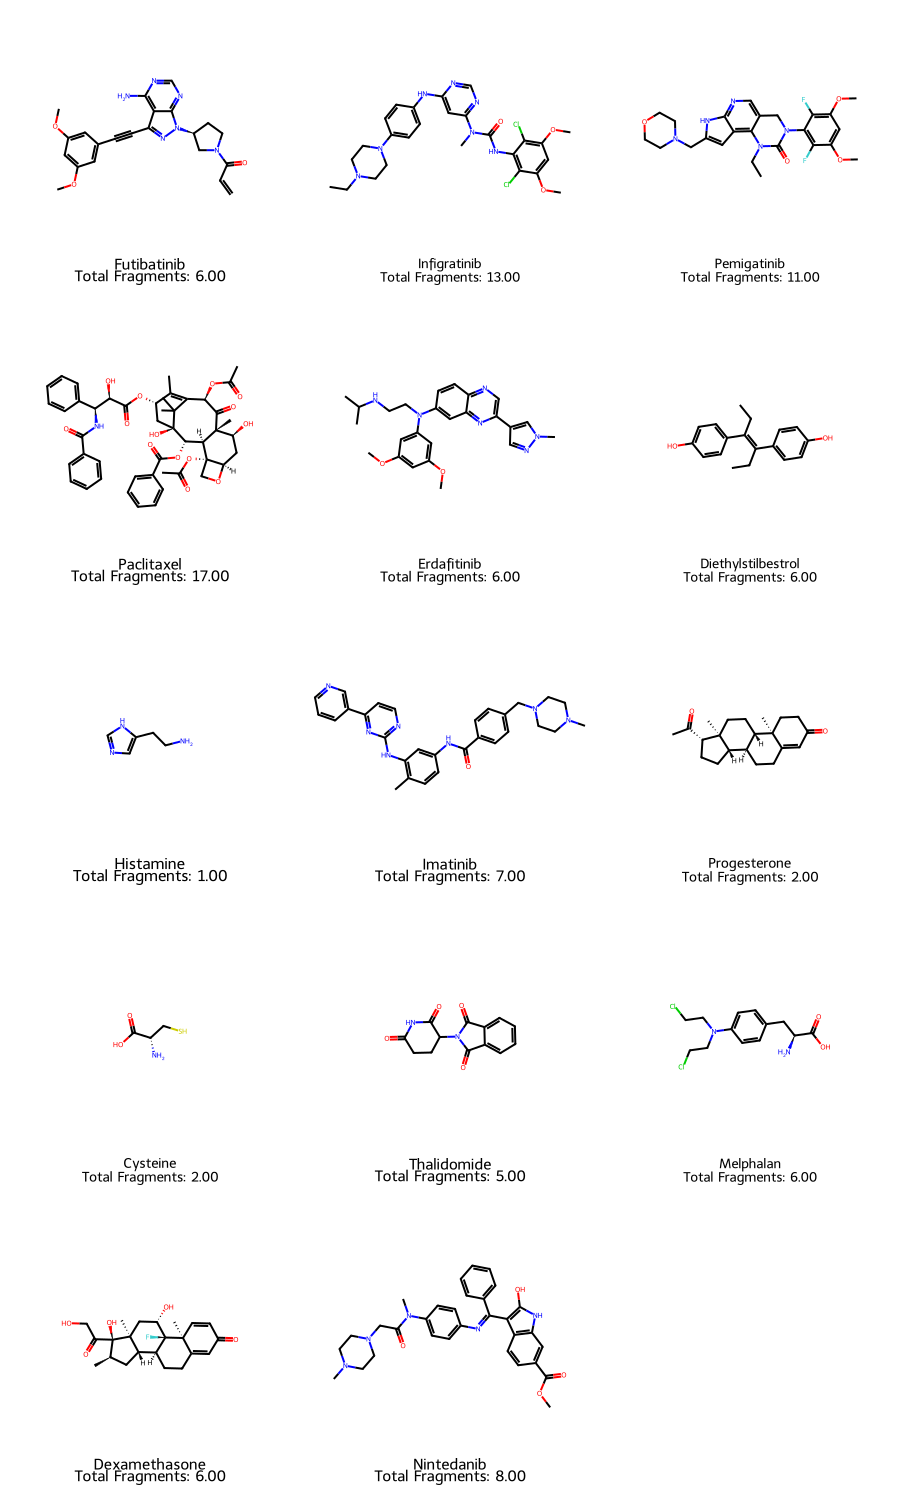

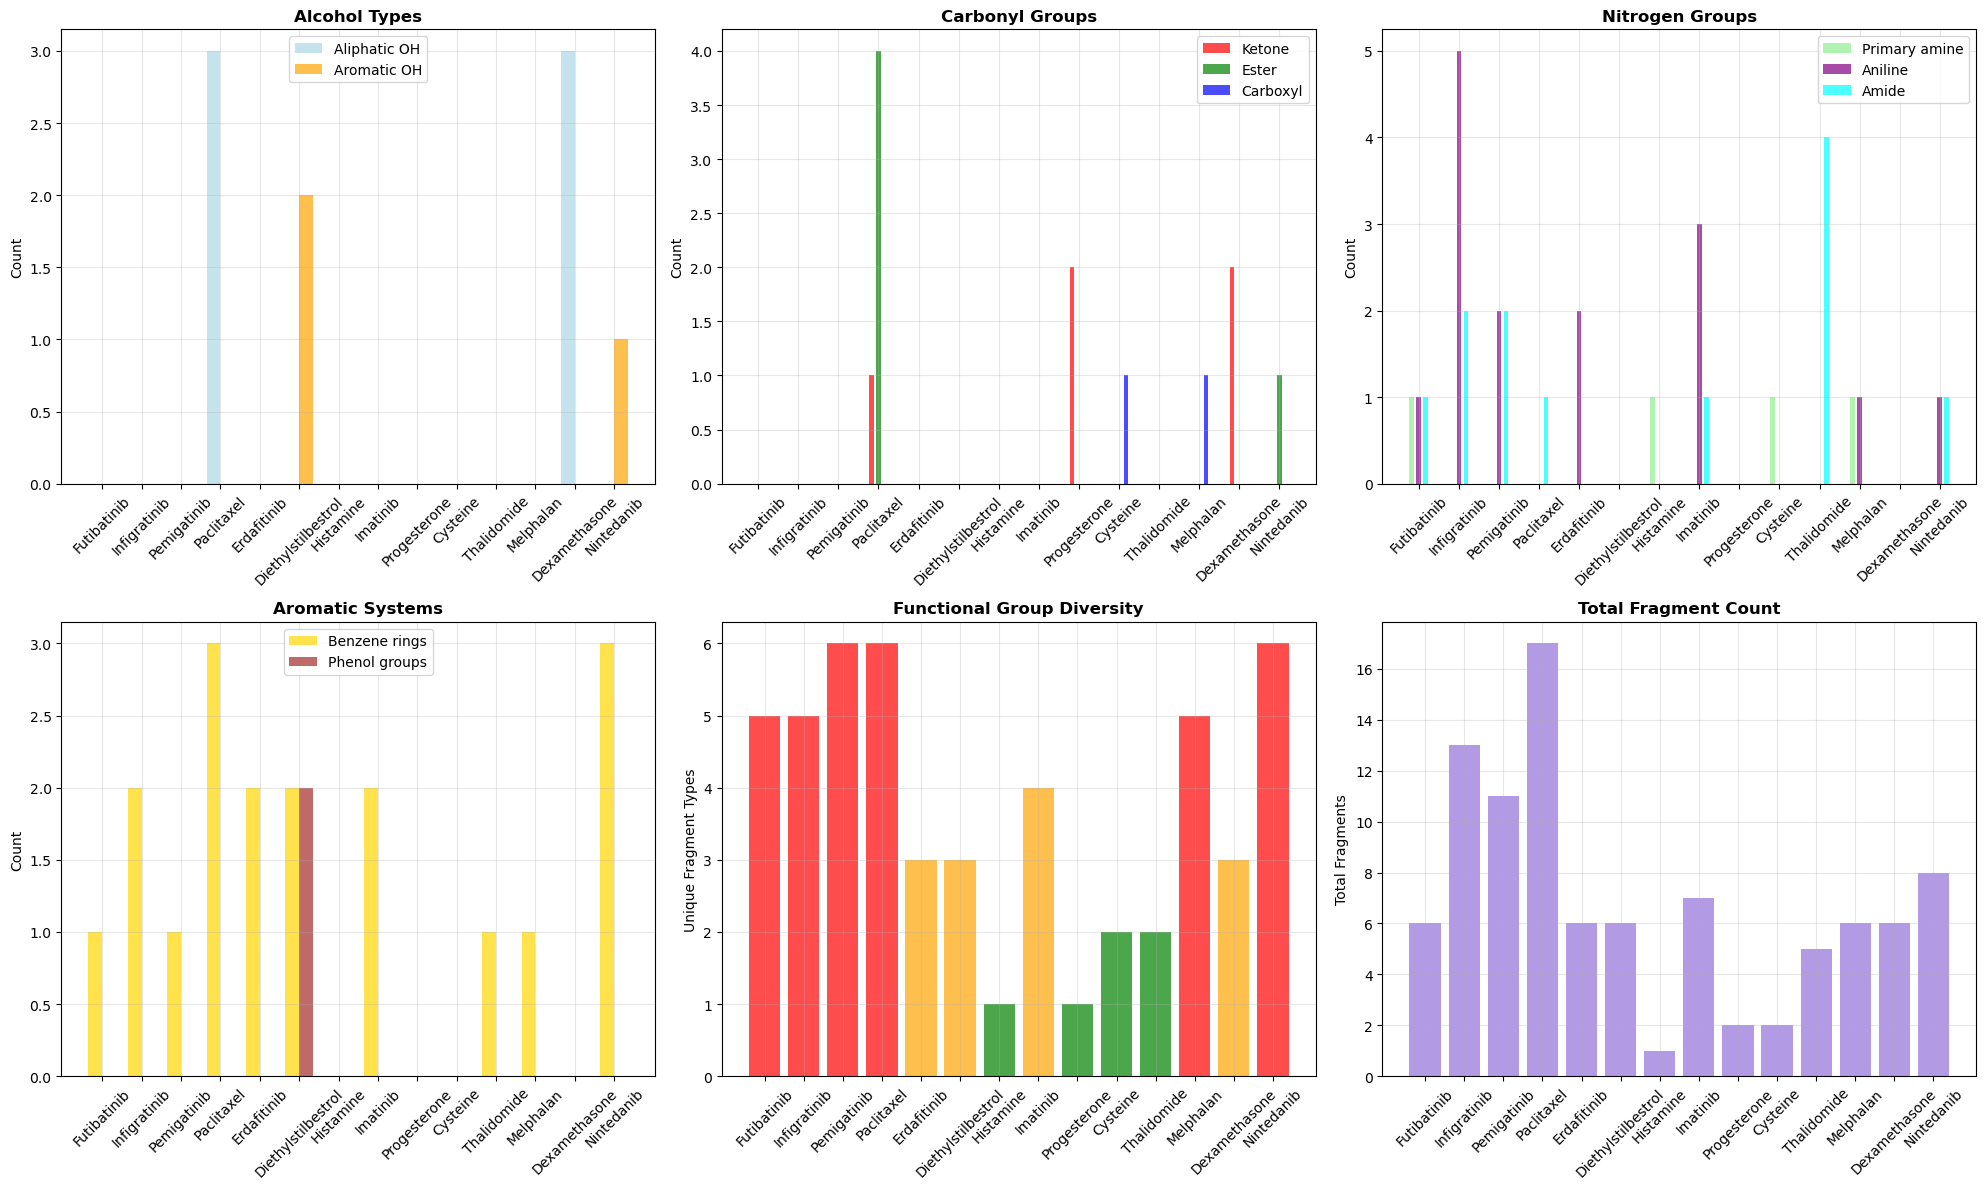

Fragment Applications:
-----------------------------------
 Drug design: Identifying pharmacophores and toxicophores
ADMET prediction: Metabolic liability assessment
 Activity prediction: Structure-activity relationships
Potential Toxicophore Analysis:
----------------------------------------

Futibatinib:  Aromatic amine (potential carcinogen)

Infigratinib:  Aromatic amine (potential carcinogen); Halogen (potential toxicity)

Pemigatinib:  Aromatic amine (potential carcinogen); Halogen (potential toxicity)

Paclitaxel: No major toxicophore alerts

Erdafitinib:  Aromatic amine (potential carcinogen)

Diethylstilbestrol: No major toxicophore alerts

Histamine: No major toxicophore alerts

Imatinib:  Aromatic amine (potential carcinogen)

Progesterone: No major toxicophore alerts

Cysteine: No major toxicophore alerts

Thalidomide: No major toxicophore alerts

Melphalan:  Aromatic amine (potential carcinogen); Halogen (potential toxicity)

Dexamethasone:  Halogen (potential toxicity)

N

In [14]:
# Fragment Descriptors Analysis

# Get all fragment descriptors
fragment_descriptors = [name for name, func in Descriptors._descList if name.startswith('fr_')]
print(f"Total Fragment Descriptors: {len(fragment_descriptors)}")

# Examples showcasing different functional groups
fragment_examples = [
    "CCO",                                          # Alcohol
    "CC(=O)C",                                      # Ketone  
    "CC(=O)OC1=CC=CC=C1C(=O)O",                     # Aspirin (ester, carboxylic acid, benzene)
    "CCN",                                          # Primary amine
    "C1=CC=C(C=C1)N",                              # Aniline (aromatic amine)
    "CN1C=NC2=C1C(=O)N(C(=O)N2C)C",                # Caffeine (multiple N-containing rings)
    "CC1=CC=C(CC1)C(C)(C)C",                       # p-tert-butylmethylbenzene
    "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O",               # Ibuprofen (carboxylic acid, branched)
    "C1=CC=C2C(=C1)C(=CC=C2)O",                    # 2-Naphthol (phenol, bicyclic)
    "CC(=O)NC1=CC=C(C=C1)O",                       # Acetaminophen (amide, phenol)
]

fragment_names = ["Ethanol", "Acetone", "Aspirin", "Ethylamine", "Aniline", 
                 "Caffeine", "Aromatic", "Ibuprofen", "Naphthol", "Acetaminophen"]


# if you want to see for previous drug molecules uncommnet the below, it will override with drug molecules 
fragment_examples = list(drug_smiles.values())
fragment_names   = list(drug_smiles.keys())

# Key fragment descriptors to analyze
key_fragments = [
    'fr_Al_OH', 'fr_Ar_OH', 'fr_ketone', 'fr_ester', 'fr_COO', 
    'fr_NH2', 'fr_aniline', 'fr_amide', 'fr_benzene', 'fr_phenol',
    'fr_halogen', 'fr_ether', 'fr_aldehyde', 'fr_pyridine'
]

# Calculate fragment descriptors
fragment_df = compare_descriptors(fragment_examples, key_fragments, fragment_names)

print(" Key Fragment Analysis")
print("=" * 80)
print(fragment_df)

# Visualize molecules
total_fragments = []
for smiles in fragment_examples:
    desc = getMolDescriptors(smiles)
    total = sum([desc.get(frag, 0) for frag in key_fragments])
    total_fragments.append(total)

img = visualize_molecules_with_properties(fragment_examples, fragment_names, total_fragments, "Total Fragments")
display(img)

# Create fragment analysis dashboard
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Alcohol types (aliphatic vs aromatic)
al_oh = [getMolDescriptors(smiles)['fr_Al_OH'] for smiles in fragment_examples]
ar_oh = [getMolDescriptors(smiles)['fr_Ar_OH'] for smiles in fragment_examples]

width = 0.35
x = np.arange(len(fragment_names))
axes[0,0].bar(x - width/2, al_oh, width, label='Aliphatic OH', alpha=0.7, color='lightblue')
axes[0,0].bar(x + width/2, ar_oh, width, label='Aromatic OH', alpha=0.7, color='orange')
axes[0,0].set_title('Alcohol Types', fontweight='bold')
axes[0,0].set_ylabel('Count')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(fragment_names, rotation=45)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Carbonyl groups
ketone = [getMolDescriptors(smiles)['fr_ketone'] for smiles in fragment_examples]
ester = [getMolDescriptors(smiles)['fr_ester'] for smiles in fragment_examples]
carbox = [getMolDescriptors(smiles)['fr_COO'] for smiles in fragment_examples]

axes[0,1].bar(x - width/2, ketone, width/3, label='Ketone', alpha=0.7, color='red')
axes[0,1].bar(x, ester, width/3, label='Ester', alpha=0.7, color='green')
axes[0,1].bar(x + width/2, carbox, width/3, label='Carboxyl', alpha=0.7, color='blue')
axes[0,1].set_title('Carbonyl Groups', fontweight='bold')
axes[0,1].set_ylabel('Count')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(fragment_names, rotation=45)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Nitrogen groups
nh2 = [getMolDescriptors(smiles)['fr_NH2'] for smiles in fragment_examples]
aniline = [getMolDescriptors(smiles)['fr_aniline'] for smiles in fragment_examples]
amide = [getMolDescriptors(smiles)['fr_amide'] for smiles in fragment_examples]

axes[0,2].bar(x - width/2, nh2, width/3, label='Primary amine', alpha=0.7, color='lightgreen')
axes[0,2].bar(x, aniline, width/3, label='Aniline', alpha=0.7, color='purple')
axes[0,2].bar(x + width/2, amide, width/3, label='Amide', alpha=0.7, color='cyan')
axes[0,2].set_title('Nitrogen Groups', fontweight='bold')
axes[0,2].set_ylabel('Count')
axes[0,2].set_xticks(x)
axes[0,2].set_xticklabels(fragment_names, rotation=45)
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# Aromatic systems
benzene = [getMolDescriptors(smiles)['fr_benzene'] for smiles in fragment_examples]
phenol = [getMolDescriptors(smiles)['fr_phenol'] for smiles in fragment_examples]

axes[1,0].bar(x - width/2, benzene, width, label='Benzene rings', alpha=0.7, color='gold')
axes[1,0].bar(x + width/2, phenol, width, label='Phenol groups', alpha=0.7, color='brown')
axes[1,0].set_title('Aromatic Systems', fontweight='bold')
axes[1,0].set_ylabel('Count')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(fragment_names, rotation=45)
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Functional group diversity
diversity_scores = []
for smiles in fragment_examples:
    desc = getMolDescriptors(smiles)
    fragment_counts = [desc.get(frag, 0) for frag in key_fragments]
    diversity = sum(1 for count in fragment_counts if count > 0)  # Number of different fragment types
    diversity_scores.append(diversity)

colors_div = ['green' if d <= 2 else 'orange' if d <= 4 else 'red' for d in diversity_scores]
axes[1,1].bar(fragment_names, diversity_scores, color=colors_div, alpha=0.7)
axes[1,1].set_title('Functional Group Diversity', fontweight='bold')
axes[1,1].set_ylabel('Unique Fragment Types')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

# Fragment complexity (total fragments)
axes[1,2].bar(fragment_names, total_fragments, color='mediumpurple', alpha=0.7)
axes[1,2].set_title('Total Fragment Count', fontweight='bold')
axes[1,2].set_ylabel('Total Fragments')
axes[1,2].tick_params(axis='x', rotation=45)
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Fragment Applications:")
print("-" * 35)
print(" Drug design: Identifying pharmacophores and toxicophores")
print("ADMET prediction: Metabolic liability assessment")
print(" Activity prediction: Structure-activity relationships")

# Toxicophore analysis
print("Potential Toxicophore Analysis:")
print("-" * 40)

toxicophores = {
    'fr_aniline': 'Aromatic amine (potential carcinogen)',
    'fr_nitro': 'Nitro group (mutagenic potential)', 
    'fr_halogen': 'Halogen (potential toxicity)',
    'fr_aldehyde': 'Aldehyde (reactive, toxic)',
    'fr_epoxide': 'Epoxide (highly reactive)',
    'fr_azo': 'Azo group (potential carcinogen)'
}

for smiles, name in zip(fragment_examples, fragment_names):
    desc = getMolDescriptors(smiles)
    toxicity_alerts = []
    
    for tox_frag, description in toxicophores.items():
        if desc.get(tox_frag, 0) > 0:
            toxicity_alerts.append(description)
    
    if toxicity_alerts:
        print(f"\n{name}:  {'; '.join(toxicity_alerts)}")
    else:
        print(f"\n{name}: No major toxicophore alerts")

### Toxicity ?
Here we see some of the drugs are potentially toxic.

Generally certain cancer drugs, that are particularly chemotherapy, are inherently toxic. 
They are designed to kill rapidly dividing cancer cells, but this mechanism also affects healthy, 
rapidly dividing cells, leading to various side effects. 
While these drugs are crucial for treating cancer, they can cause significant toxicities, both short-term and long-term.

# Surface Area (VSA) Descriptors

Van der Waals Surface Area descriptors partition molecular surface area based on atomic properties like charge, lipophilicity, and molar refractivity.


 Total VSA Descriptors: 59
 Surface Area (VSA) Analysis
              Molecule                                             SMILES  \
0          Futibatinib  COC1=CC(=CC(=C1)C#CC2=NN(C3=NC=NC(=C23)N)[C@H]...   
1         Infigratinib  CCN1CCN(CC1)C2=CC=C(C=C2)NC3=CC(=NC=N3)N(C)C(=...   
2          Pemigatinib  CCN1C2=C3C=C(NC3=NC=C2CN(C1=O)C4=C(C(=CC(=C4F)...   
3           Paclitaxel  CC1=C2[C@H](C(=O)[C@@]3([C@H](C[C@@H]4[C@]([C@...   
4          Erdafitinib  CC(C)NCCN(C1=CC2=NC(=CN=C2C=C1)C3=CN(N=C3)C)C4...   
5   Diethylstilbestrol        CC/C(=C(/CC)\C1=CC=C(C=C1)O)/C2=CC=C(C=C2)O   
6            Histamine                                     C1=C(NC=N1)CCN   
7             Imatinib  CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C...   
8         Progesterone  CC(=O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2CCC4...   
9             Cysteine                                C([C@@H](C(=O)O)N)S   
10         Thalidomide             C1CC(=O)NC(=O)C1N2C(=O)C3=CC=CC=C3C2=O   
11           Melphal

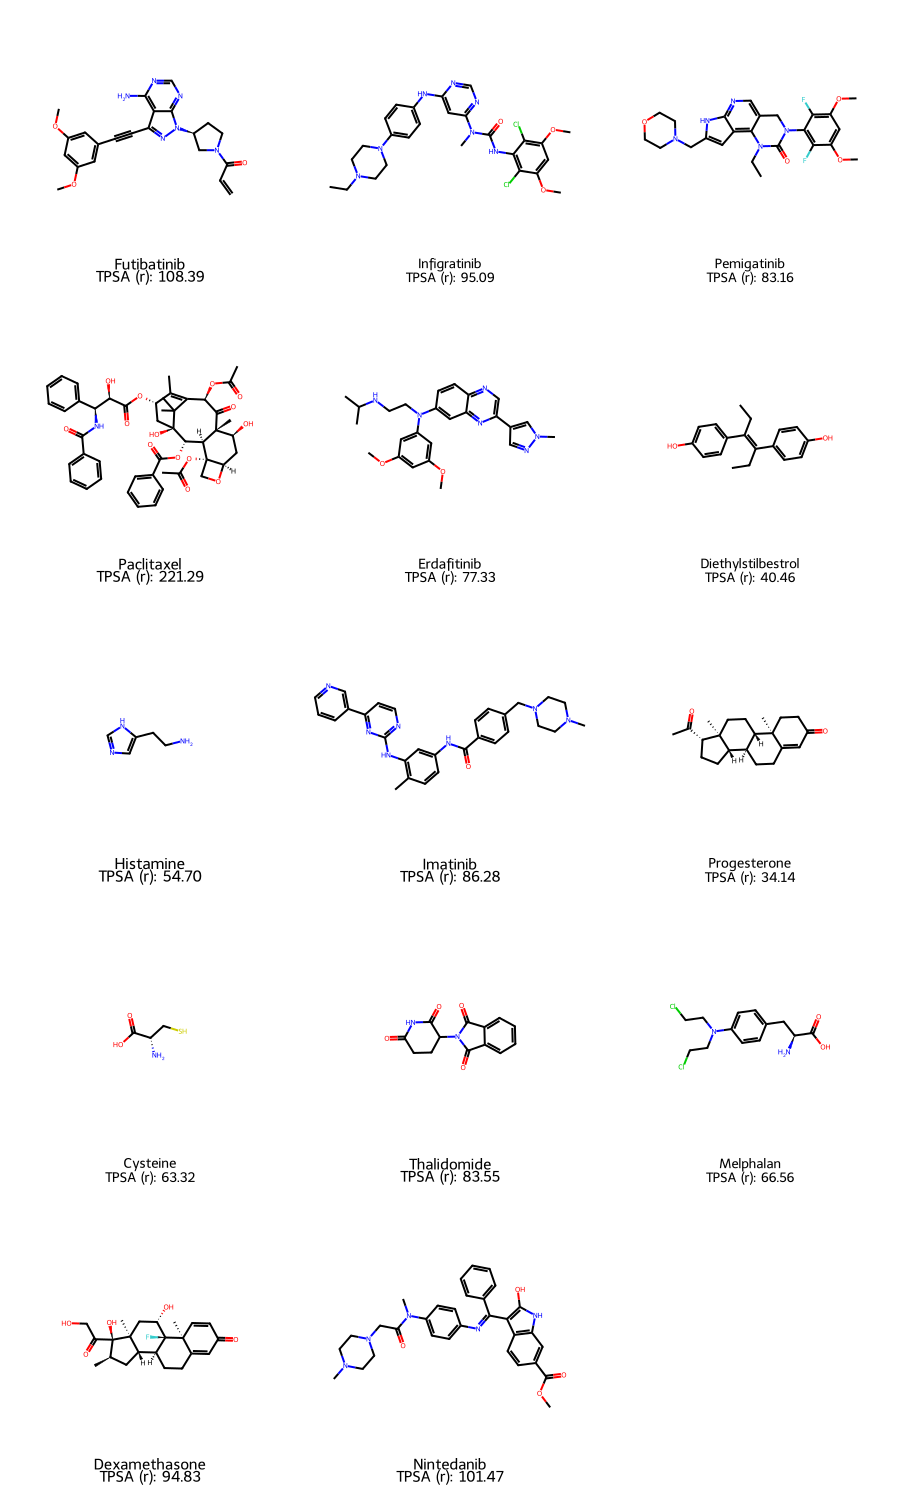

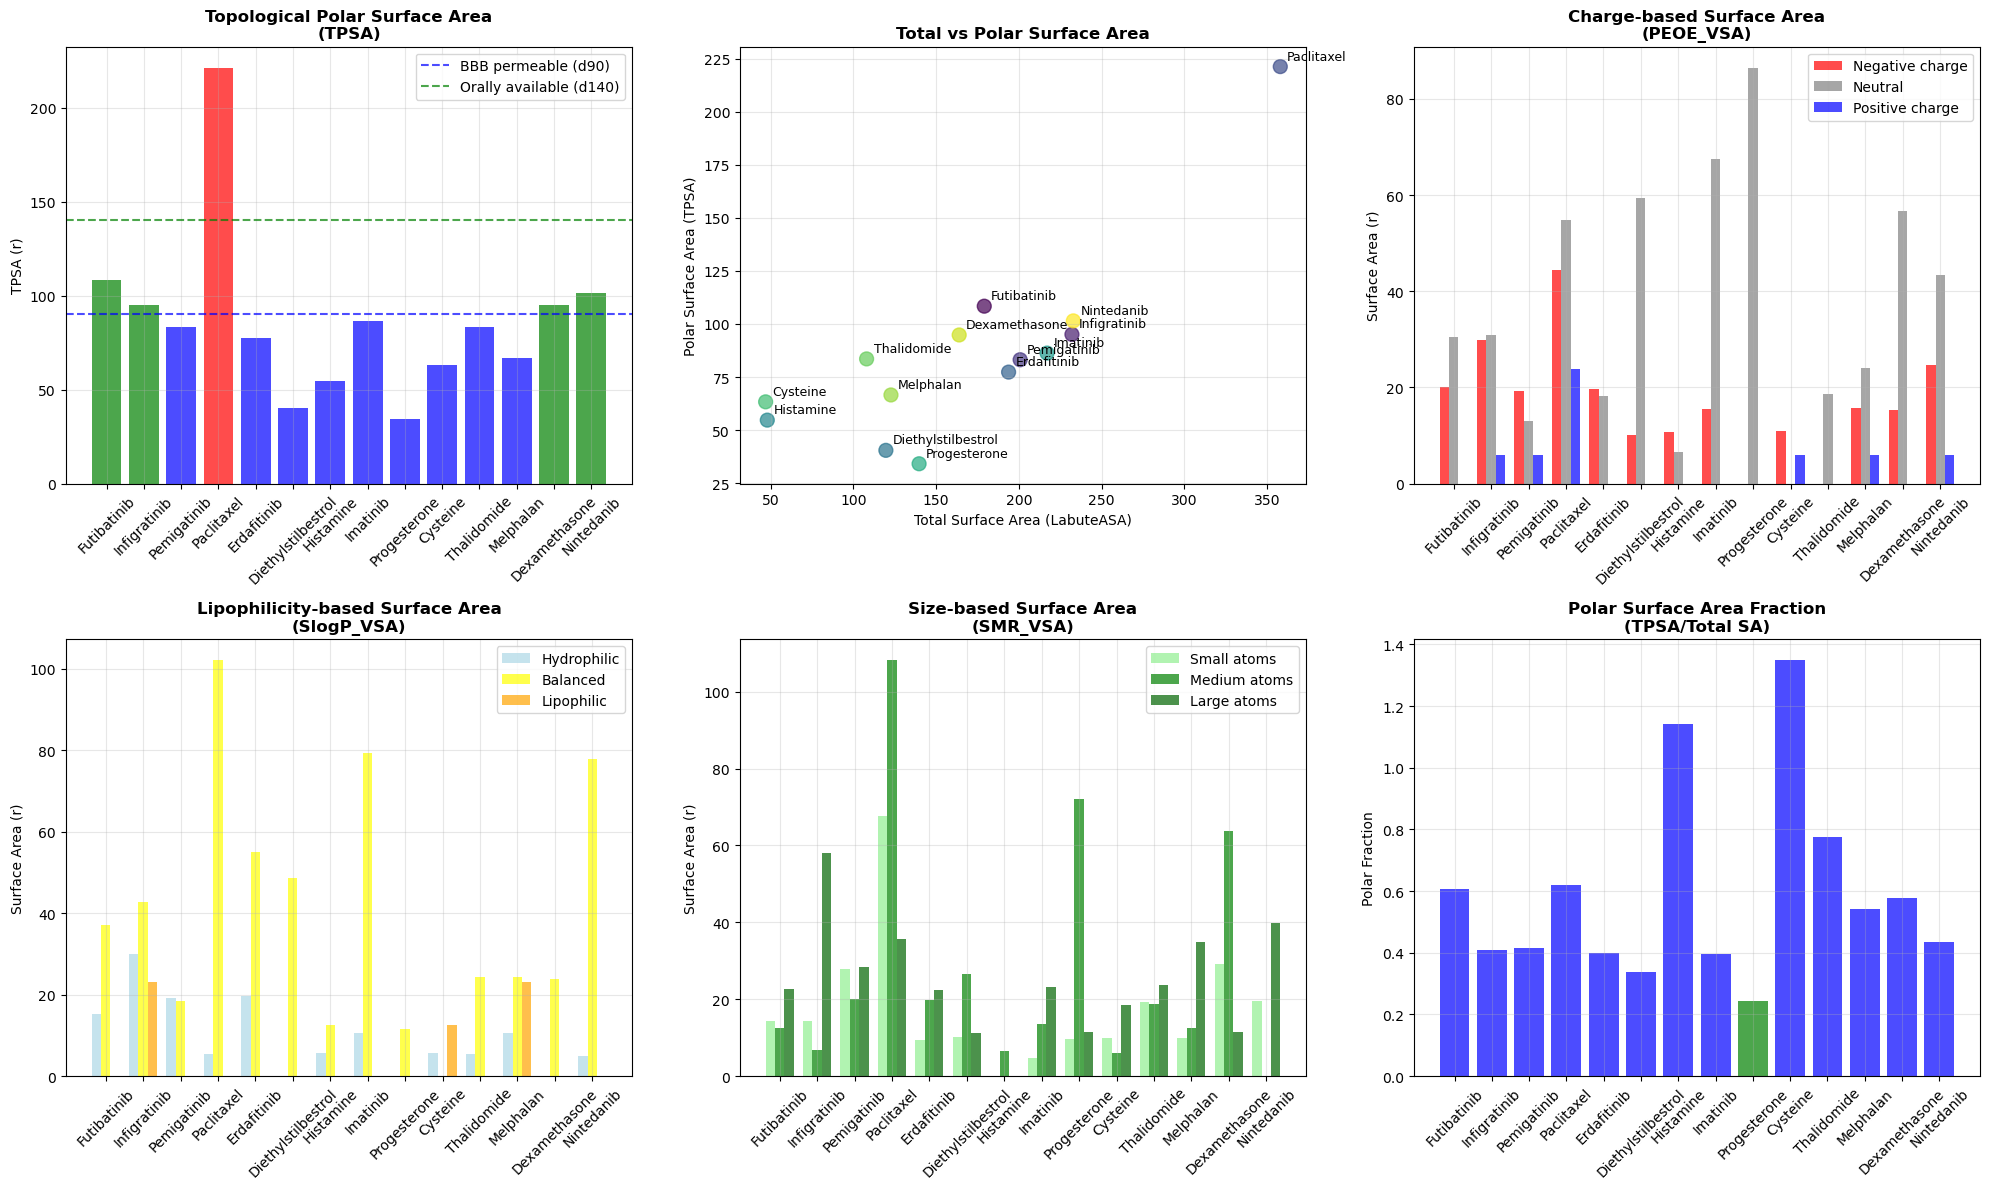

 VSA Applications:
-----------------------------------
Permeability prediction: TPSA for membrane crossing
ADMET modeling: Surface property distribution
Drug design: Balancing polar/non-polar regions
Permeability Assessment:
Based on TPSA (Topological Polar Surface Area):
 d 90 r  : Blood-Brain Barrier permeable
 90-140 r: Orally bioavailable
 > 140 r : Poor permeability
 Individual Permeability Assessments:
--------------------------------------------------

Futibatinib:
  TPSA: 108.4 r
  Total SA: 179.0 r
  Polar fraction: 0.605 (Highly polar)
  Permeability:  Orally bioavailable

Infigratinib:
  TPSA: 95.1 r
  Total SA: 232.0 r
  Polar fraction: 0.410 (Highly polar)
  Permeability:  Orally bioavailable

Pemigatinib:
  TPSA: 83.2 r
  Total SA: 200.7 r
  Polar fraction: 0.414 (Highly polar)
  Permeability:  BBB permeable

Paclitaxel:
  TPSA: 221.3 r
  Total SA: 357.9 r
  Polar fraction: 0.618 (Highly polar)
  Permeability: L Poor permeability

Erdafitinib:
  TPSA: 77.3 r
  Total SA: 1

In [15]:
#  Surface Area (VSA) Descriptors Analysis

# Get all VSA descriptors
vsa_descriptors = [name for name, func in Descriptors._descList if 'VSA' in name or name in ['TPSA', 'LabuteASA']]
print(f" Total VSA Descriptors: {len(vsa_descriptors)}")

# Examples with different surface area characteristics
vsa_examples = [
    "CCO",                                          # Small, polar
    "CCCCCCCCCC",                                   # Linear, non-polar
    "CC(C)(C)C(C)(C)C",                            # Branched, non-polar
    "C1=CC=CC=C1",                                 # Aromatic, medium polarity
    "CC(=O)OC1=CC=CC=C1C(=O)O",                    # Aspirin - mixed polarity
    "CN1C=NC2=C1C(=O)N(C(=O)N2C)C",                # Caffeine - polar heterocycles
    "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O",               # Ibuprofen - mixed properties
    "CCCCCCCCCCCCCCCC",                            # Long chain - very lipophilic
]

vsa_names = ["Ethanol", "Decane", "Branched", "Benzene", "Aspirin", "Caffeine", "Ibuprofen", "Palmitic chain"]


# if you want to see for previous drug molecules uncommnet the below, it will override with drug molecules 
vsa_examples = list(drug_smiles.values())
vsa_names   = list(drug_smiles.keys())

# Key VSA descriptors to analyze
key_vsa = [
    'TPSA', 'LabuteASA',
    'PEOE_VSA1', 'PEOE_VSA7', 'PEOE_VSA14',  # Charge-based (negative, neutral, positive)
    'SlogP_VSA1', 'SlogP_VSA6', 'SlogP_VSA12', # Lipophilicity-based (hydrophilic, balanced, lipophilic)
    'SMR_VSA1', 'SMR_VSA5', 'SMR_VSA10',     # Molar refractivity-based (small, medium, large)
    'EState_VSA1', 'EState_VSA6', 'EState_VSA11'  # EState-based (electron-rich, neutral, electron-poor)
]

# Calculate VSA descriptors
vsa_df = compare_descriptors(vsa_examples, key_vsa, vsa_names)

print(" Surface Area (VSA) Analysis")
print("=" * 80)
print(vsa_df)

# Visualize molecules with TPSA values
tpsa_values = [getMolDescriptors(smiles)['TPSA'] for smiles in vsa_examples]
img = visualize_molecules_with_properties(vsa_examples, vsa_names, tpsa_values, "TPSA (r)")
display(img)

# Comprehensive VSA analysis
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# TPSA analysis (permeability prediction)
tpsa_colors = ['blue' if tpsa <= 90 else 'green' if tpsa <= 140 else 'red' for tpsa in tpsa_values]
axes[0,0].bar(vsa_names, tpsa_values, color=tpsa_colors, alpha=0.7)
axes[0,0].axhline(y=90, color='blue', linestyle='--', alpha=0.7, label='BBB permeable (d90)')
axes[0,0].axhline(y=140, color='green', linestyle='--', alpha=0.7, label='Orally available (d140)')
axes[0,0].set_title('Topological Polar Surface Area\n(TPSA)', fontweight='bold')
axes[0,0].set_ylabel('TPSA (r)')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Total surface area comparison
labute_values = [getMolDescriptors(smiles)['LabuteASA'] for smiles in vsa_examples]
axes[0,1].scatter(labute_values, tpsa_values, s=100, alpha=0.7, c=range(len(vsa_names)), cmap='viridis')
for i, name in enumerate(vsa_names):
    axes[0,1].annotate(name, (labute_values[i], tpsa_values[i]), 
                      xytext=(5, 5), textcoords='offset points', fontsize=9)
axes[0,1].set_xlabel('Total Surface Area (LabuteASA)')
axes[0,1].set_ylabel('Polar Surface Area (TPSA)')
axes[0,1].set_title('Total vs Polar Surface Area', fontweight='bold')
axes[0,1].grid(True, alpha=0.3)

# Charge-based VSA distribution
peoe_neg = [getMolDescriptors(smiles)['PEOE_VSA1'] for smiles in vsa_examples]  # Most negative
peoe_neu = [getMolDescriptors(smiles)['PEOE_VSA7'] for smiles in vsa_examples]  # Neutral
peoe_pos = [getMolDescriptors(smiles)['PEOE_VSA14'] for smiles in vsa_examples] # Most positive

width = 0.25
x = np.arange(len(vsa_names))
axes[0,2].bar(x - width, peoe_neg, width, label='Negative charge', alpha=0.7, color='red')
axes[0,2].bar(x, peoe_neu, width, label='Neutral', alpha=0.7, color='gray')
axes[0,2].bar(x + width, peoe_pos, width, label='Positive charge', alpha=0.7, color='blue')
axes[0,2].set_title('Charge-based Surface Area\n(PEOE_VSA)', fontweight='bold')
axes[0,2].set_ylabel('Surface Area (r)')
axes[0,2].set_xticks(x)
axes[0,2].set_xticklabels(vsa_names, rotation=45)
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# Lipophilicity-based VSA distribution
slogp_hydro = [getMolDescriptors(smiles)['SlogP_VSA1'] for smiles in vsa_examples]   # Hydrophilic
slogp_bal = [getMolDescriptors(smiles)['SlogP_VSA6'] for smiles in vsa_examples]     # Balanced
slogp_lipo = [getMolDescriptors(smiles)['SlogP_VSA12'] for smiles in vsa_examples]   # Lipophilic

axes[1,0].bar(x - width, slogp_hydro, width, label='Hydrophilic', alpha=0.7, color='lightblue')
axes[1,0].bar(x, slogp_bal, width, label='Balanced', alpha=0.7, color='yellow')
axes[1,0].bar(x + width, slogp_lipo, width, label='Lipophilic', alpha=0.7, color='orange')
axes[1,0].set_title('Lipophilicity-based Surface Area\n(SlogP_VSA)', fontweight='bold')
axes[1,0].set_ylabel('Surface Area (r)')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(vsa_names, rotation=45)
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Molar refractivity-based VSA distribution
smr_small = [getMolDescriptors(smiles)['SMR_VSA1'] for smiles in vsa_examples]   # Small atoms
smr_med = [getMolDescriptors(smiles)['SMR_VSA5'] for smiles in vsa_examples]     # Medium atoms
smr_large = [getMolDescriptors(smiles)['SMR_VSA10'] for smiles in vsa_examples]  # Large atoms

axes[1,1].bar(x - width, smr_small, width, label='Small atoms', alpha=0.7, color='lightgreen')
axes[1,1].bar(x, smr_med, width, label='Medium atoms', alpha=0.7, color='green')
axes[1,1].bar(x + width, smr_large, width, label='Large atoms', alpha=0.7, color='darkgreen')
axes[1,1].set_title('Size-based Surface Area\n(SMR_VSA)', fontweight='bold')
axes[1,1].set_ylabel('Surface Area (r)')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(vsa_names, rotation=45)
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# Polar vs Non-polar surface area ratio
polar_ratios = [tpsa/labute if labute > 0 else 0 for tpsa, labute in zip(tpsa_values, labute_values)]
colors_ratio = ['blue' if r > 0.3 else 'green' if r > 0.1 else 'orange' for r in polar_ratios]
axes[1,2].bar(vsa_names, polar_ratios, color=colors_ratio, alpha=0.7)
axes[1,2].set_title('Polar Surface Area Fraction\n(TPSA/Total SA)', fontweight='bold')
axes[1,2].set_ylabel('Polar Fraction')
axes[1,2].tick_params(axis='x', rotation=45)
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(" VSA Applications:")
print("-" * 35)
print("Permeability prediction: TPSA for membrane crossing")
print("ADMET modeling: Surface property distribution")
print("Drug design: Balancing polar/non-polar regions")

print("Permeability Assessment:")
print("=" * 40)
print("Based on TPSA (Topological Polar Surface Area):")
print(" d 90 r  : Blood-Brain Barrier permeable")
print(" 90-140 r: Orally bioavailable")
print(" > 140 r : Poor permeability")

print(" Individual Permeability Assessments:")
print("-" * 50)
for i, name in enumerate(vsa_names):
    if tpsa_values[i] <= 90:
        permeability = " BBB permeable"
        color = "Blue"
    elif tpsa_values[i] <= 140:
        permeability = " Orally bioavailable"
        color = "Green"
    else:
        permeability = "L Poor permeability"
        color = "Red"
    
    polar_fraction = polar_ratios[i]
    character = "Highly polar" if polar_fraction > 0.3 else "Moderately polar" if polar_fraction > 0.1 else "Non-polar"
    
    print(f"\n{name}:")
    print(f"  TPSA: {tpsa_values[i]:.1f} r")
    print(f"  Total SA: {labute_values[i]:.1f} r")
    print(f"  Polar fraction: {polar_fraction:.3f} ({character})")
    print(f"  Permeability: {permeability}")

# Interactive Analysis Tool

=Interactive Molecular Analysis Tool
Enter any SMILES string to get a comprehensive descriptor analysis!
 Example Analyses:
------------------------------
 Analyzing: Aspirin
SMILES: CC(=O)OC1=CC=CC=C1C(=O)O
------------------------------------------------------------


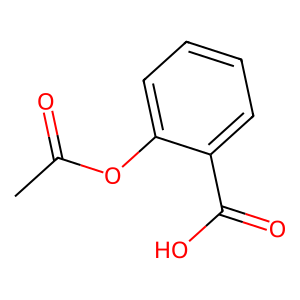

Basic Properties:
  MolWt: 180.16
  ExactMolWt: 180.04
  HeavyAtomCount: 13.00
  NumValenceElectrons: 68.00
 Physicochemical Properties:
  MolLogP: 1.310
  MolMR: 44.710
  qed: 0.550
  SPS: 9.308
 Lipinski's Rule of Five Analysis:
  Molecular Weight: 180.2 Da (d500)
 LogP: 1.31 (d5)
  H-bond Donors: 1 (d5)
 H-bond Acceptors: 3 (d10)

   Total Violations: 0/4
 Assessment: Good drug-likeness
 ADMET Predictions:
  TPSA: 63.6 r - BBB permeable
 Rotatable Bonds: 2 (d10 - good flexibility)
 Structural Features:
  RingCount: 1.000
  NumAromaticRings: 1.000
  FractionCSP3: 0.111
  NumAtomStereoCenters: 0.000
Major Functional Groups:
Benzene: 1
Ester: 1
Coo: 1
 Overall Assessment:
  Drug-likeness (QED): 0.550
  Structural Complexity: 343.2
   Moderate drug-like properties
 Analyzing: Caffeine
SMILES: CN1C=NC2=C1C(=O)N(C(=O)N2C)C
------------------------------------------------------------


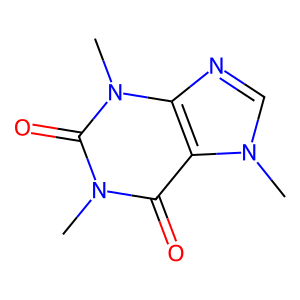

Basic Properties:
  MolWt: 194.19
  ExactMolWt: 194.08
  HeavyAtomCount: 14.00
  NumValenceElectrons: 74.00
 Physicochemical Properties:
  MolLogP: -1.029
  MolMR: 51.196
  qed: 0.538
  SPS: 11.071
 Lipinski's Rule of Five Analysis:
  Molecular Weight: 194.2 Da (d500)
 LogP: -1.03 (d5)
  H-bond Donors: 0 (d5)
 H-bond Acceptors: 6 (d10)

   Total Violations: 0/4
 Assessment: Good drug-likeness
 ADMET Predictions:
  TPSA: 61.8 r - BBB permeable
 Rotatable Bonds: 0 (d10 - good flexibility)
 Structural Features:
  RingCount: 2.000
  NumAromaticRings: 2.000
  FractionCSP3: 0.375
  NumAtomStereoCenters: 0.000
Major Functional Groups:
 No major functional groups detected
 Overall Assessment:
  Drug-likeness (QED): 0.538
  Structural Complexity: 616.5
   Moderate drug-like properties
 Analyzing: Ibuprofen
SMILES: CC(C)CC1=CC=C(C=C1)C(C)C(=O)O
------------------------------------------------------------


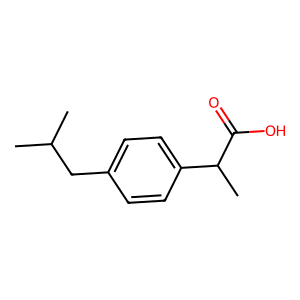

Basic Properties:
  MolWt: 206.28
  ExactMolWt: 206.13
  HeavyAtomCount: 15.00
  NumValenceElectrons: 82.00
 Physicochemical Properties:
  MolLogP: 3.073
  MolMR: 61.035
  qed: 0.822
  SPS: 12.800
 Lipinski's Rule of Five Analysis:
  Molecular Weight: 206.3 Da (d500)
 LogP: 3.07 (d5)
  H-bond Donors: 1 (d5)
 H-bond Acceptors: 1 (d10)

   Total Violations: 0/4
 Assessment: Good drug-likeness
 ADMET Predictions:
  TPSA: 37.3 r - BBB permeable
 Rotatable Bonds: 4 (d10 - good flexibility)
 Structural Features:
  RingCount: 1.000
  NumAromaticRings: 1.000
  FractionCSP3: 0.462
  NumAtomStereoCenters: 1.000
Major Functional Groups:
Benzene: 1
Coo: 1
 Overall Assessment:
  Drug-likeness (QED): 0.822
  Structural Complexity: 324.9
   Excellent drug-like properties


In [16]:
def analyze_molecule(smiles, molecule_name="Unknown"):
    """Comprehensive molecular analysis using all RDKit descriptors"""
    
    print(f" Analyzing: {molecule_name}")
    print(f"SMILES: {smiles}")
    print("-" * 60)
    
    # Calculate all descriptors
    descriptors = getMolDescriptors(smiles)
    if not descriptors:
        return None
    
    # Create molecule visualization
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        img = Draw.MolToImage(mol, size=(300, 300))
        display(img)
    
    # Basic properties
    print("Basic Properties:")
    basic_props = ['MolWt', 'ExactMolWt', 'HeavyAtomCount', 'NumValenceElectrons']
    for prop in basic_props:
        value = descriptors.get(prop, 0)
        print(f"  {prop}: {value:.2f}")
    
    # Physicochemical properties
    print(" Physicochemical Properties:")
    physico_props = ['MolLogP', 'MolMR', 'qed', 'SPS']
    for prop in physico_props:
        value = descriptors.get(prop, 0)
        print(f"  {prop}: {value:.3f}")
    
    # Lipinski's Rule of Five analysis
    print(" Lipinski's Rule of Five Analysis:")
    mw = descriptors.get('MolWt', 0)
    logp = descriptors.get('MolLogP', 0)
    hbd = descriptors.get('NumHDonors', 0)
    hba = descriptors.get('NumHAcceptors', 0)
    
    violations = 0
    if mw > 500:
        violations += 1
        print(f"  L Molecular Weight: {mw:.1f} Da (>500)")
    else:
        print(f"  Molecular Weight: {mw:.1f} Da (d500)")
    
    if logp > 5:
        violations += 1
        print(f"  L LogP: {logp:.2f} (>5)")
    else:
        print(f" LogP: {logp:.2f} (d5)")
    
    if hbd > 5:
        violations += 1
        print(f"  L H-bond Donors: {hbd} (>5)")
    else:
        print(f"  H-bond Donors: {hbd} (d5)")
    
    if hba > 10:
        violations += 1
        print(f"  L H-bond Acceptors: {hba} (>10)")
    else:
        print(f" H-bond Acceptors: {hba} (d10)")
    
    print(f"\n   Total Violations: {violations}/4")
    if violations <= 1:
        print(" Assessment: Good drug-likeness")
    else:
        print("  Assessment: Poor drug-likeness")
    
    # ADMET predictions
    print(" ADMET Predictions:")
    tpsa = descriptors.get('TPSA', 0)
    rotbonds = descriptors.get('NumRotatableBonds', 0)
    
    if tpsa <= 90:
        print(f"  TPSA: {tpsa:.1f} r - BBB permeable")
    elif tpsa <= 140:
        print(f" TPSA: {tpsa:.1f} r - Orally bioavailable")
    else:
        print(f"  L TPSA: {tpsa:.1f} r - Poor permeability")
    
    if rotbonds <= 10:
        print(f" Rotatable Bonds: {rotbonds} (d10 - good flexibility)")
    else:
        print(f"  Rotatable Bonds: {rotbonds} (>10 - high flexibility)")
    
    # Structural features
    print(" Structural Features:")
    struct_props = ['RingCount', 'NumAromaticRings', 'FractionCSP3', 'NumAtomStereoCenters']
    for prop in struct_props:
        value = descriptors.get(prop, 0)
        print(f"  {prop}: {value:.3f}")
    
    # Fragment analysis (top fragments only)
    print("Major Functional Groups:")
    fragment_props = ['fr_benzene', 'fr_Al_OH', 'fr_Ar_OH', 'fr_ketone', 'fr_ester', 
                     'fr_COO', 'fr_NH2', 'fr_aniline', 'fr_amide', 'fr_halogen']
    
    found_fragments = []
    for prop in fragment_props:
        value = descriptors.get(prop, 0)
        if value > 0:
            fragment_name = prop.replace('fr_', '').replace('_', ' ').title()
            found_fragments.append(f"{fragment_name}: {value}")
    
    if found_fragments:
        for frag in found_fragments:
            print(f"{frag}")
    else:
        print(" No major functional groups detected")
    
    # Overall assessment
    qed_score = descriptors.get('qed', 0)
    complexity = descriptors.get('BertzCT', 0)
    
    print(f" Overall Assessment:")
    print(f"  Drug-likeness (QED): {qed_score:.3f}")
    print(f"  Structural Complexity: {complexity:.1f}")
    
    if qed_score >= 0.67:
        drug_assessment = " Excellent drug-like properties"
    elif qed_score >= 0.3:
        drug_assessment = " Moderate drug-like properties"
    else:
        drug_assessment = "=4 Poor drug-like properties"
    
    print(f"  {drug_assessment}")
    
    return descriptors

# Example analyses
print("=Interactive Molecular Analysis Tool")
print("=" * 50)
print("Enter any SMILES string to get a comprehensive descriptor analysis!")

print(" Example Analyses:")
print("-" * 30)

example_molecules = [
    ("CC(=O)OC1=CC=CC=C1C(=O)O", "Aspirin"),
    ("CN1C=NC2=C1C(=O)N(C(=O)N2C)C", "Caffeine"),
    ("CC(C)CC1=CC=C(C=C1)C(C)C(=O)O", "Ibuprofen")
]

for smiles, name in example_molecules:
    analyze_molecule(smiles, name)




# Summary & Applications

In [17]:
#  RDKit Descriptors Summary & Applications


print(" RDKit Descriptors Summary")
print("=" * 60)

# Get all descriptor categories and counts
all_descriptors = [name for name, func in Descriptors._descList]
total_descriptors = len(all_descriptors)

categories = {
    'Basic Properties': ['MolWt', 'ExactMolWt', 'HeavyAtomMolWt', 'NumValenceElectrons', 'NumRadicalElectrons'],
    'Physicochemical': ['MolLogP', 'MolMR', 'qed', 'SPS'],
    'Charge Properties': ['MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge'],
    'EState Descriptors': ['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex'],
    'BCUT Descriptors': ['BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW'],
    'Topological': [d for d in all_descriptors if any(x in d for x in ['Chi', 'Kappa', 'BalabanJ', 'BertzCT', 'Ipc', 'Phi', 'HallKierAlpha', 'AvgIpc'])],
    'Surface Area (VSA)': [d for d in all_descriptors if 'VSA' in d or d in ['TPSA', 'LabuteASA']],
    'Structural Counts': [d for d in all_descriptors if d.startswith('Num') or d in ['RingCount', 'FractionCSP3', 'HeavyAtomCount', 'NHOHCount', 'NOCount'] or d.startswith('FpDensity')],
    'Fragment Counts': [d for d in all_descriptors if d.startswith('fr_')],
}

print(f" Total RDKit Descriptors: {total_descriptors}")
print(" Descriptor Categories:")
print("-" * 40)

for category, descriptors in categories.items():
    count = len(descriptors)
    percentage = (count / total_descriptors) * 100
    print(f"{category:<20}: {count:>3} descriptors ({percentage:.1f}%)")



print(" Summary Statistics:")
print("=" * 30)
print(f"Total descriptors covered: {total_descriptors}")
print(f"Most useful categories: Basic Properties, Physicochemical, Structural Counts")
print(f"Essential for drug discovery: ~30-50 key descriptors")
print(f"Complete molecular characterization: All 217 descriptors")


print("Now we have some understanding of RDKit descriptors guide!")


 RDKit Descriptors Summary
 Total RDKit Descriptors: 217
 Descriptor Categories:
----------------------------------------
Basic Properties    :   5 descriptors (2.3%)
Physicochemical     :   4 descriptors (1.8%)
Charge Properties   :   4 descriptors (1.8%)
EState Descriptors  :   4 descriptors (1.8%)
BCUT Descriptors    :   8 descriptors (3.7%)
Topological         :  21 descriptors (9.7%)
Surface Area (VSA)  :  59 descriptors (27.2%)
Structural Counts   :  29 descriptors (13.4%)
Fragment Counts     :  85 descriptors (39.2%)
 Summary Statistics:
Total descriptors covered: 217
Most useful categories: Basic Properties, Physicochemical, Structural Counts
Essential for drug discovery: ~30-50 key descriptors
Complete molecular characterization: All 217 descriptors
Now we have some understanding of RDKit descriptors guide!
